# Rossman Stors Sales Analysis Using Linear Regression

## Problem Statement / Business Understanding

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to **six weeks** in advance. 

Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In this exercise, we are going to **predict 6 weeks of daily sales for 1,115 stores located across Germany**. 

Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust **prediction** model, we will help store managers stay focused on what’s most important to them: their customers and their teams!

### Hypothesis Statement

H0: There is no direct correlation between numbers of Rossmann customers and volumes of sales at the stores.

H1: The number of customers influence the volumes of sales at Rossmann stores. The greater the number of customers, the higher the volume of sales. The less the number of customers, the lower the volume of sales.

## Data Understanding

We have historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files

- `train.csv` - historical data including Sales
- `test.csv` - historical data excluding Sales
- `sample_submission.csv` - a sample submission file in the correct format
- `store.csv` - supplemental information about the stores

## Data Preparation

### Loading Modules

In [1]:
# Imports

import matplotlib as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

from utils.utils import draw_distribution_plots, OutlierHandler


# suppress scientific notation in Pandas
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

# Matplotlib settings
plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

# Seaborn settings
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.set_theme(style="darkgrid")

# Ignore warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 1

### Loading Data

#### Training Data

In [2]:
train_df = pd.read_csv("./sales_data/train.csv")

train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


#### Test Data

In [3]:
test_df = pd.read_csv("./sales_data/test.csv")

test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0
4,5,9,4,2015-09-17,1.00,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.00,0,0,0
41084,41085,1112,6,2015-08-01,1.00,0,0,0
41085,41086,1113,6,2015-08-01,1.00,0,0,0
41086,41087,1114,6,2015-08-01,1.00,0,0,0


#### Merging Training and Test Data

In [4]:
merged_df = pd.concat([train_df, test_df])

merged_df


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-31,"5,263.00",555.00,1.00,1,0,1,NaN
1,2,5,2015-07-31,"6,064.00",625.00,1.00,1,0,1,NaN
2,3,5,2015-07-31,"8,314.00",821.00,1.00,1,0,1,NaN
3,4,5,2015-07-31,"13,995.00","1,498.00",1.00,1,0,1,NaN
4,5,5,2015-07-31,"4,822.00",559.00,1.00,1,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,NaN,NaN,1.00,0,0,0,"41,084.00"
41084,1112,6,2015-08-01,NaN,NaN,1.00,0,0,0,"41,085.00"
41085,1113,6,2015-08-01,NaN,NaN,1.00,0,0,0,"41,086.00"
41086,1114,6,2015-08-01,NaN,NaN,1.00,0,0,0,"41,087.00"


#### Exporting Data

In [5]:
merged_df.to_csv("./sales_data/merged.csv")

#### Final DataFrame

In [6]:
df = merged_df.copy()

df = df[["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday", "SchoolHoliday"]]

df.reset_index()

df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,"5,263.00",555.00,1.00,1,0,1
1,2,5,2015-07-31,"6,064.00",625.00,1.00,1,0,1
2,3,5,2015-07-31,"8,314.00",821.00,1.00,1,0,1
3,4,5,2015-07-31,"13,995.00","1,498.00",1.00,1,0,1
4,5,5,2015-07-31,"4,822.00",559.00,1.00,1,0,1
...,...,...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,NaN,NaN,1.00,0,0,0
41084,1112,6,2015-08-01,NaN,NaN,1.00,0,0,0
41085,1113,6,2015-08-01,NaN,NaN,1.00,0,0,0
41086,1114,6,2015-08-01,NaN,NaN,1.00,0,0,0


### Inspecting Data

#### Total Rows & Cols

In [7]:
df.shape

(1058297, 9)

The training data has a total of 1,058,297 records and 9 columns. We need to inspect what this data looks like by checking the first 5 and the last 5 records. This data is not sorted yet.

#### Top and Bottom

In [8]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,"5,263.00",555.00,1.00,1,0,1
1,2,5,2015-07-31,"6,064.00",625.00,1.00,1,0,1
2,3,5,2015-07-31,"8,314.00",821.00,1.00,1,0,1
3,4,5,2015-07-31,"13,995.00","1,498.00",1.00,1,0,1
4,5,5,2015-07-31,"4,822.00",559.00,1.00,1,0,1


In [9]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
41083,1111,6,2015-08-01,NaN,NaN,1.00,0,0,0
41084,1112,6,2015-08-01,NaN,NaN,1.00,0,0,0
41085,1113,6,2015-08-01,NaN,NaN,1.00,0,0,0
41086,1114,6,2015-08-01,NaN,NaN,1.00,0,0,0
41087,1115,6,2015-08-01,NaN,NaN,1.00,0,0,1


We need to see more information about the dataframe, including the index dtype and columns, non-null values and memory usage. [Ref](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info)

#### Inspect Data Types

In [10]:
df.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1058297 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1058297 non-null  int64  
 1   DayOfWeek      1058297 non-null  int64  
 2   Date           1058297 non-null  object 
 3   Sales          1017209 non-null  float64
 4   Customers      1017209 non-null  float64
 5   Open           1058286 non-null  float64
 6   Promo          1058297 non-null  int64  
 7   StateHoliday   1058297 non-null  object 
 8   SchoolHoliday  1058297 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 172.9 MB


Some descriptive statistics, excluding string columns [Ref](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe)

#### High-level Analysis

In [11]:
df.describe(include=[np.number])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,"1,058,297.00","1,058,297.00","1,017,209.00","1,017,209.00","1,058,286.00","1,058,297.00","1,058,297.00"
mean,558.33,4.00,"5,773.82",633.15,0.83,0.38,0.19
std,321.85,2.00,"3,849.93",464.41,0.37,0.49,0.39
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.00,"3,727.00",405.00,1.00,0.00,0.00
50%,558.00,4.00,"5,744.00",609.00,1.00,0.00,0.00
75%,837.00,6.00,"7,856.00",837.00,1.00,1.00,0.00
max,"1,115.00",7.00,"41,551.00","7,388.00",1.00,1.00,1.00


### Data Analysis

In [12]:
numeric_df = df[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday']]

numeric_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
0,1,5,"5,263.00",555.00,1.00,1,1
1,2,5,"6,064.00",625.00,1.00,1,1
2,3,5,"8,314.00",821.00,1.00,1,1
3,4,5,"13,995.00","1,498.00",1.00,1,1
4,5,5,"4,822.00",559.00,1.00,1,1
...,...,...,...,...,...,...,...
41083,1111,6,NaN,NaN,1.00,0,0
41084,1112,6,NaN,NaN,1.00,0,0
41085,1113,6,NaN,NaN,1.00,0,0
41086,1114,6,NaN,NaN,1.00,0,0


#### Data Completeness

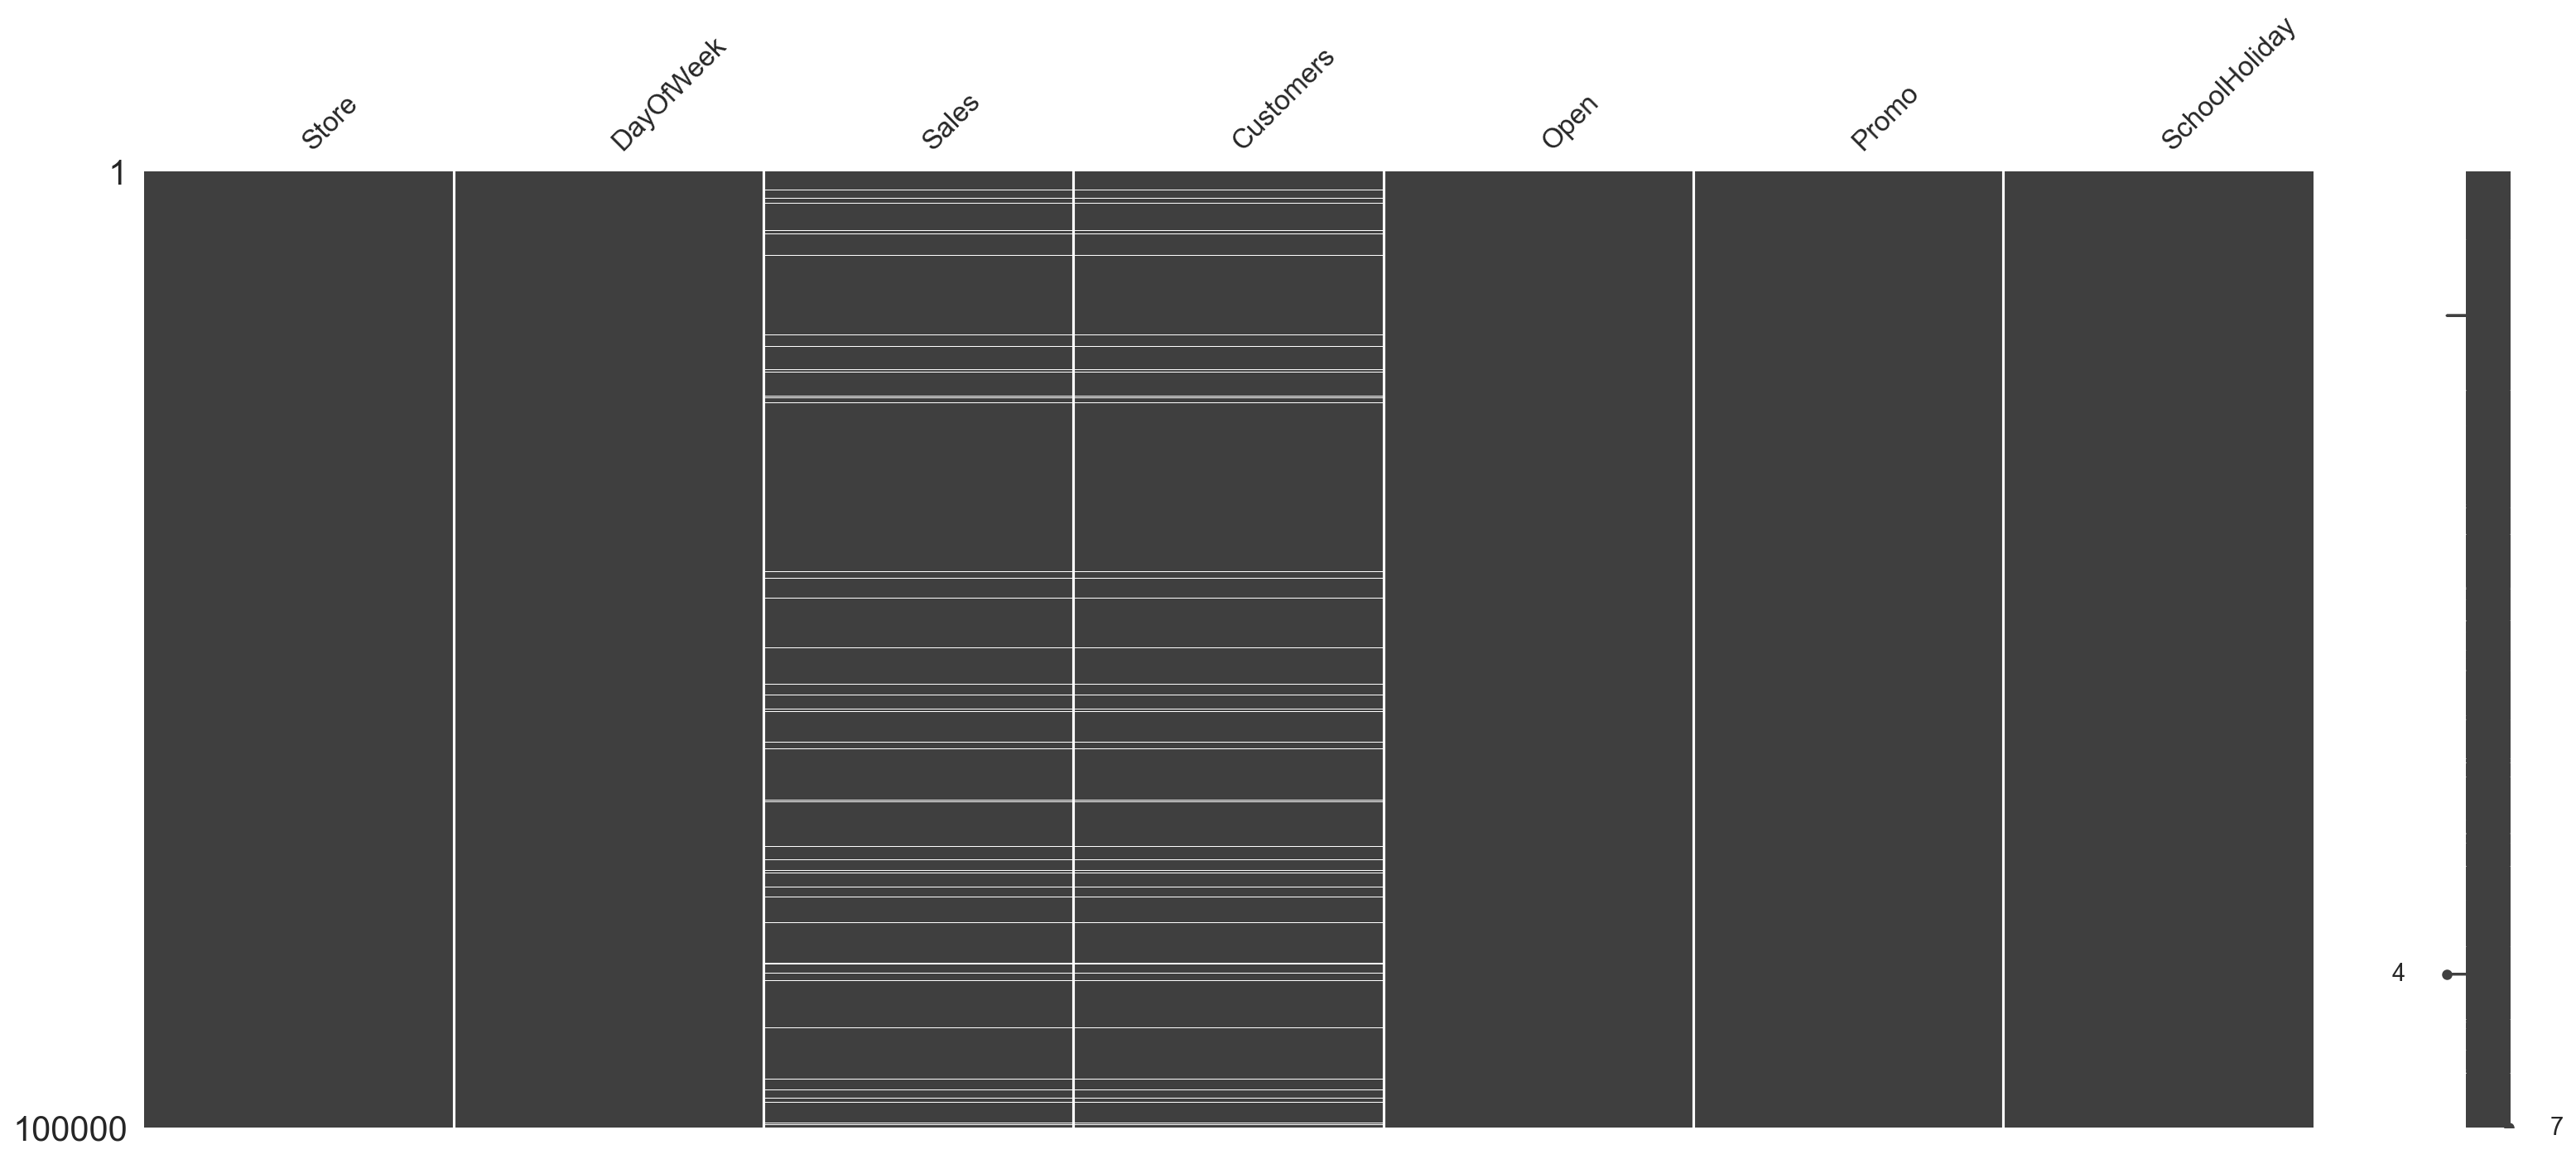

In [13]:
"""
Using missingno to visualise the completeness (or lack thereof) of the training dataset.

Ref: https://github.com/ResidentMario/missingno
"""

_ = msno.matrix(numeric_df.sample(100000))

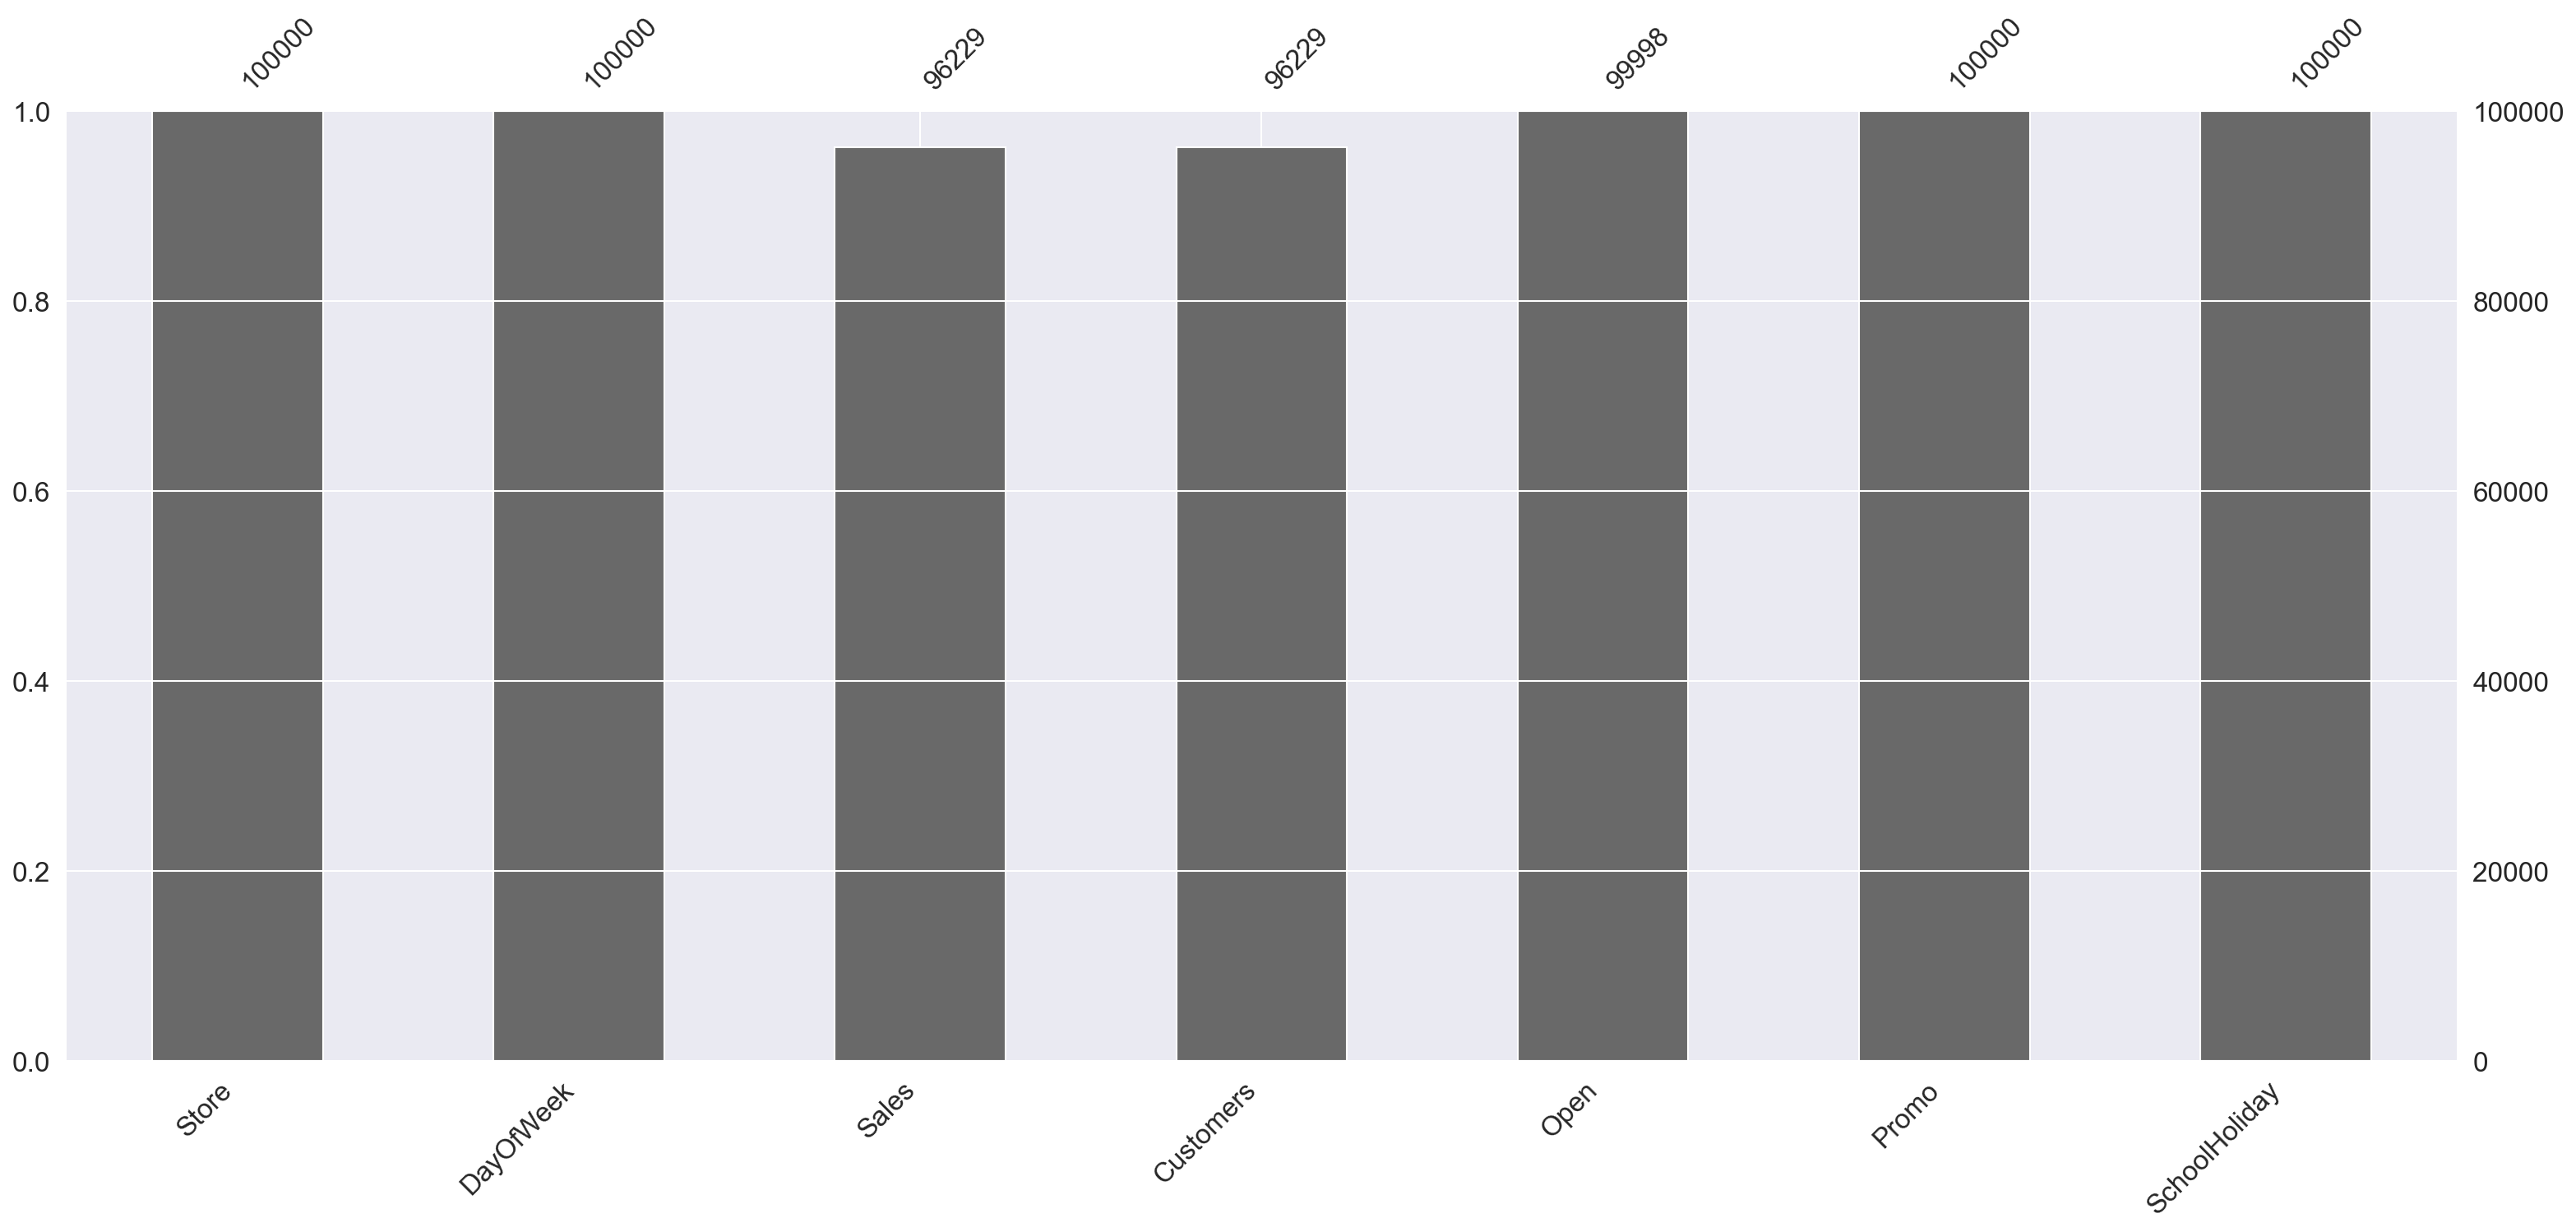

In [14]:
_ = msno.bar(numeric_df.sample(100000))

In [15]:
"""
Check for null values

Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull
Aliases: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html
"""
numeric_df.isna().sum()

Store                0
DayOfWeek            0
Sales            41088
Customers        41088
Open                11
Promo                0
SchoolHoliday        0
dtype: int64

#### Correlation Analysis

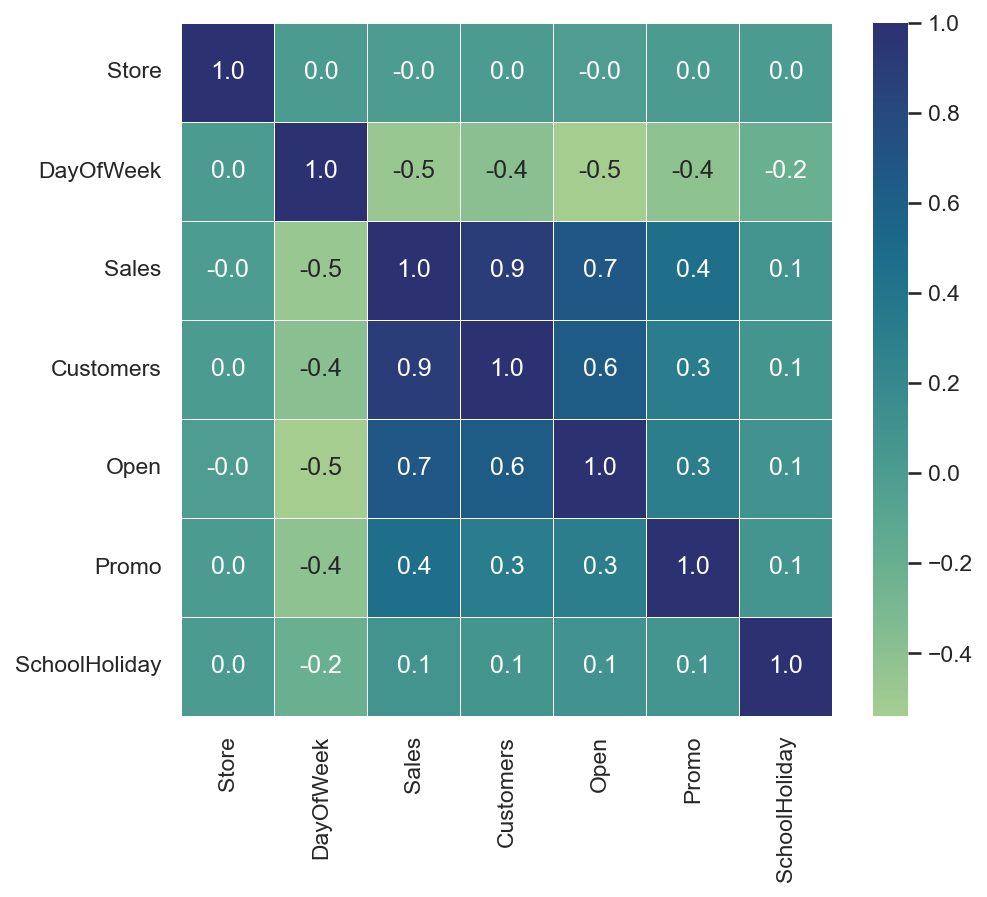

In [16]:
"""
TODO: Add Description here

Ref: https://seaborn.pydata.org/generated/seaborn.heatmap.html
"""
fig, ax = plt.pyplot.subplots(figsize=(7, 6))

_ = sns.heatmap(numeric_df.sample(5000).corr(), annot=True, fmt=".1f", linewidth=.25, cmap="crest")

**Some Notes**


- There is a very strong correlation between Sales and Customers, meaning customers influenced sales
- There is also a strong correlation betweem Open and Sales, followed by Open and Customers. We can interpret this as:
    - whenever the stores were open, there would be customers (not entirely guaranteed)
    - and whenever there were customers, there would be sales (also, not entirely guaranteed)
- There is a 50/50 correlation between Promo and Sales. This could mean 50% of the time promos influence sales
- There is lower correlation between Promo and Customers. 30% of the time that the stores have run promos there has been more customers
- School holidays influence sales and customers to a very minimal degree

For our modeling, we will focus on Customers <-> Sales

#### Analytic Distributions

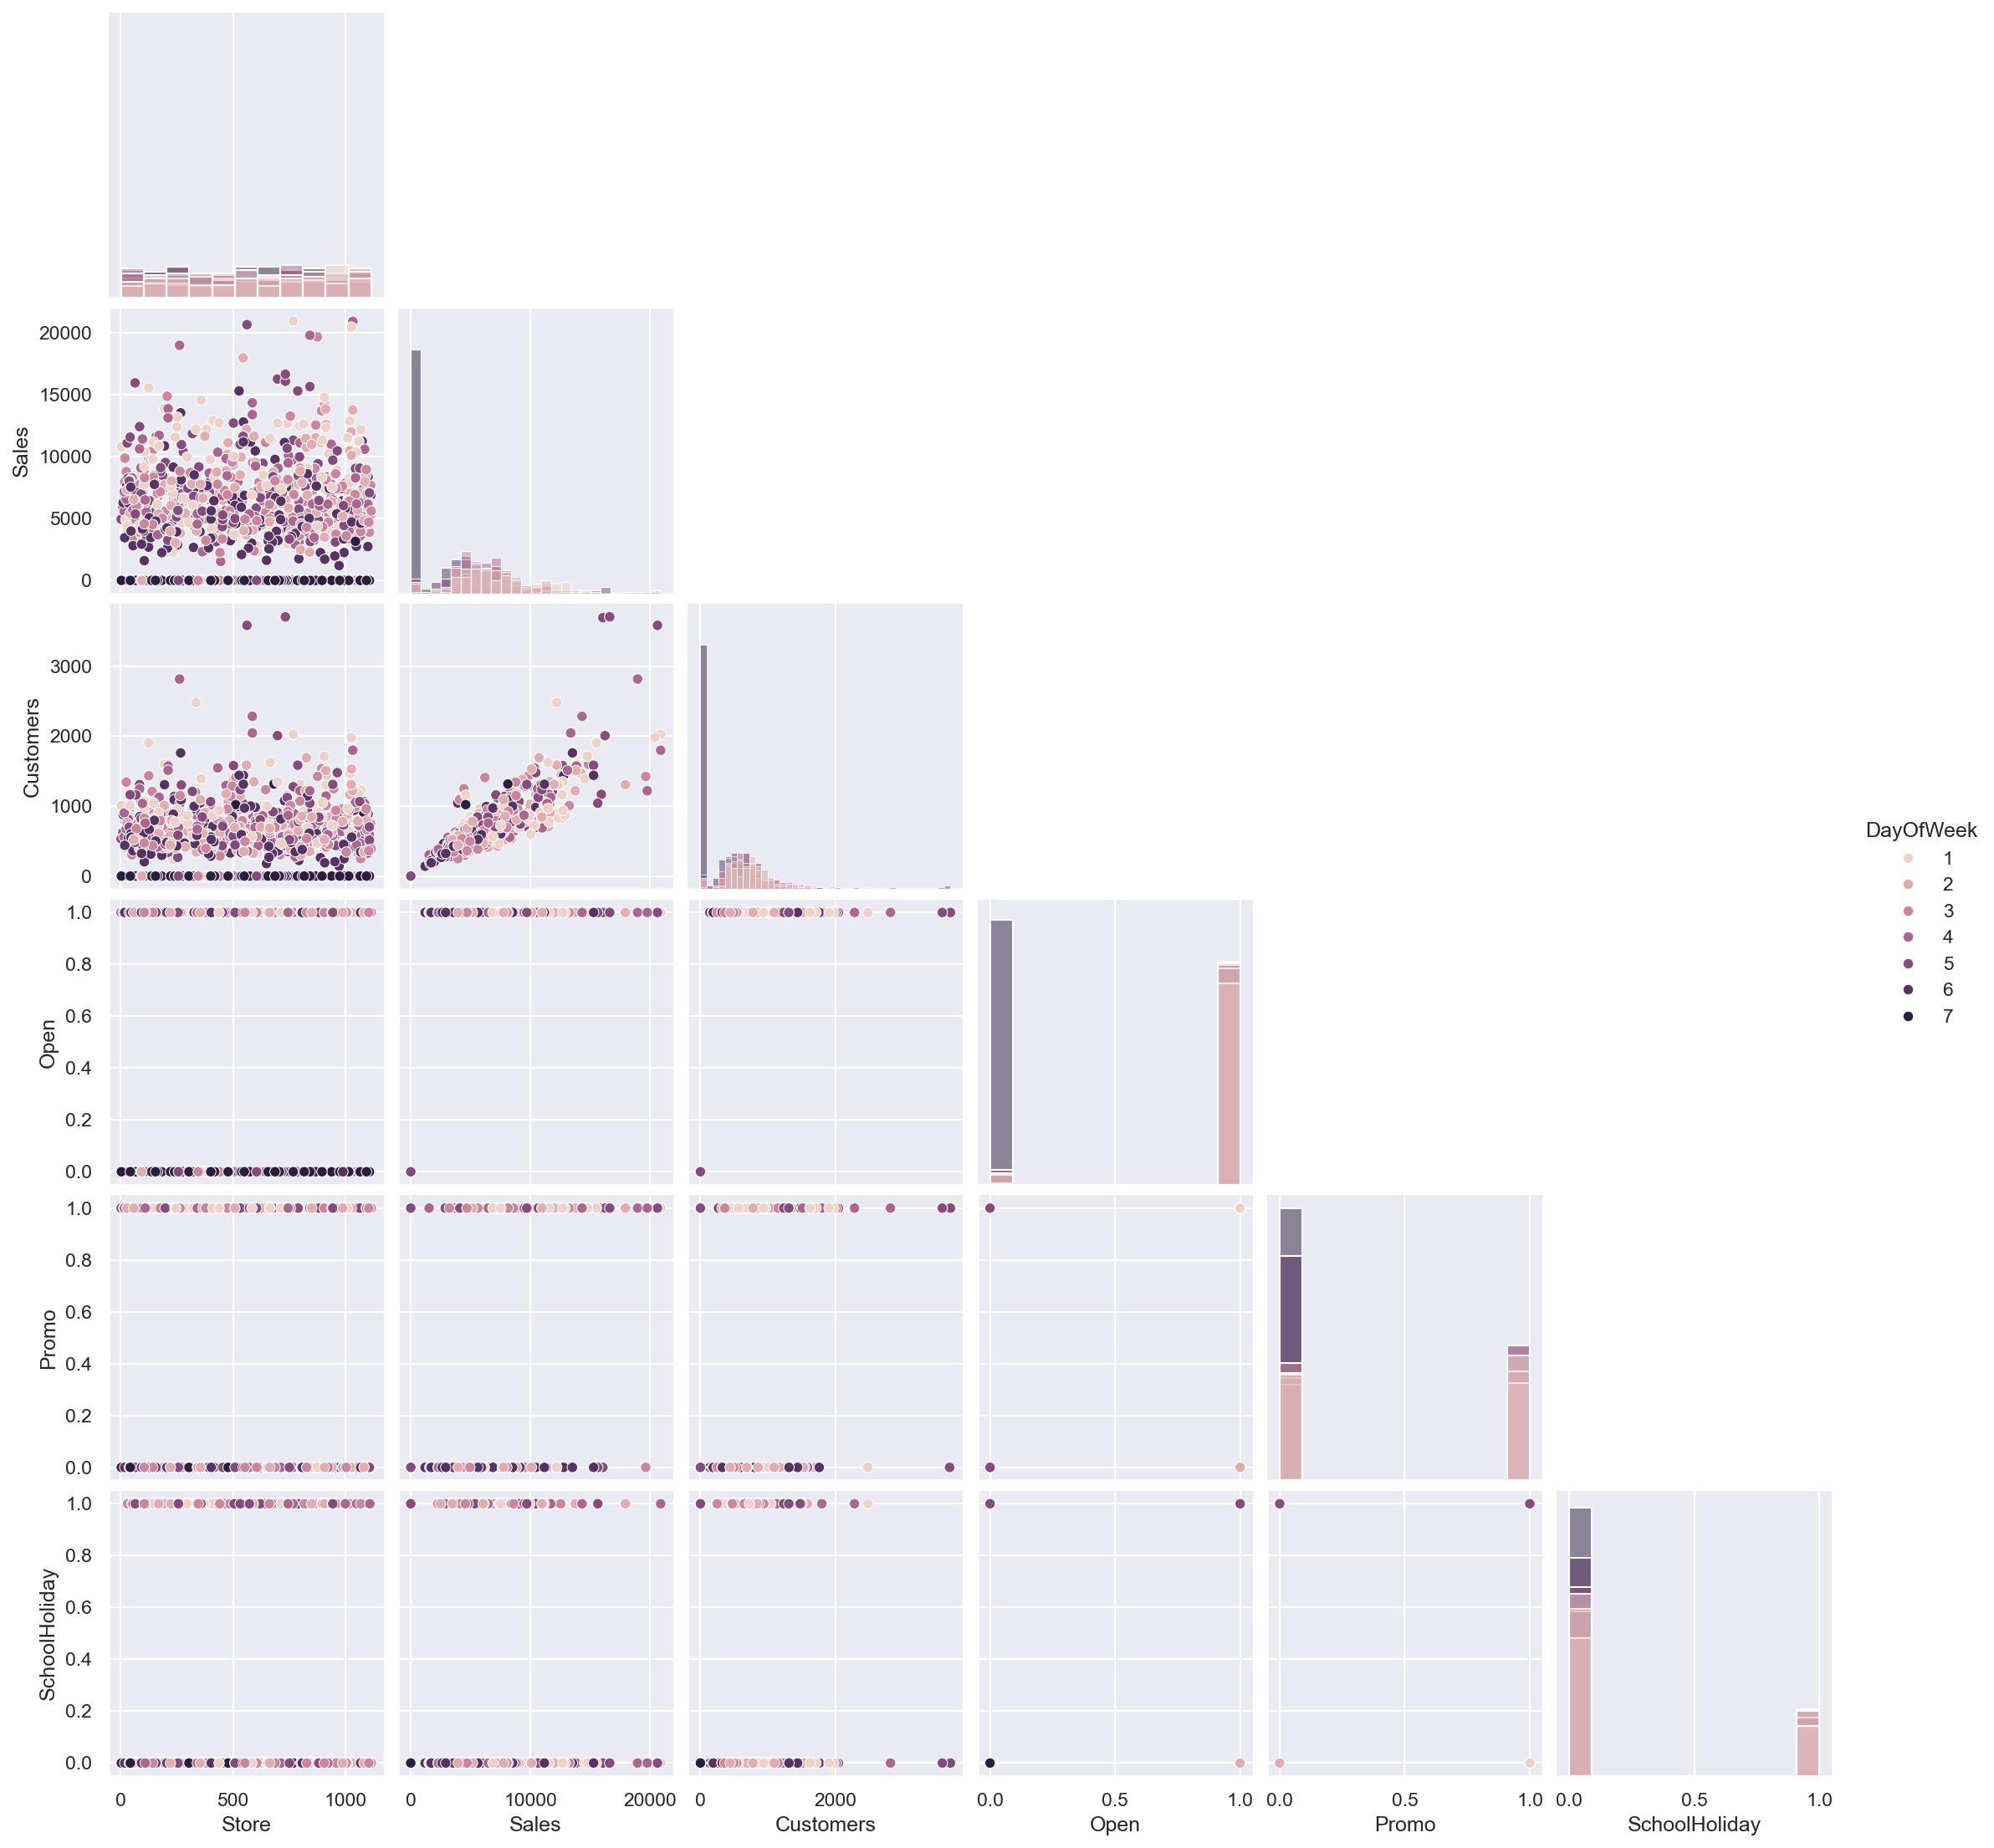

In [17]:
"""
TODO: Add Description here

Ref: https://seaborn.pydata.org/generated/seaborn.pairplot.html
"""
_ = sns.pairplot(numeric_df.sample(1000), hue="DayOfWeek", diag_kind="hist", corner=True)

**Notes**

Because there is a linear relationship between Customers and Sales, we:
- focus on those two variables for our analysis and modeling
- hypothesize that we can use a regression model for forecast sales based on customers

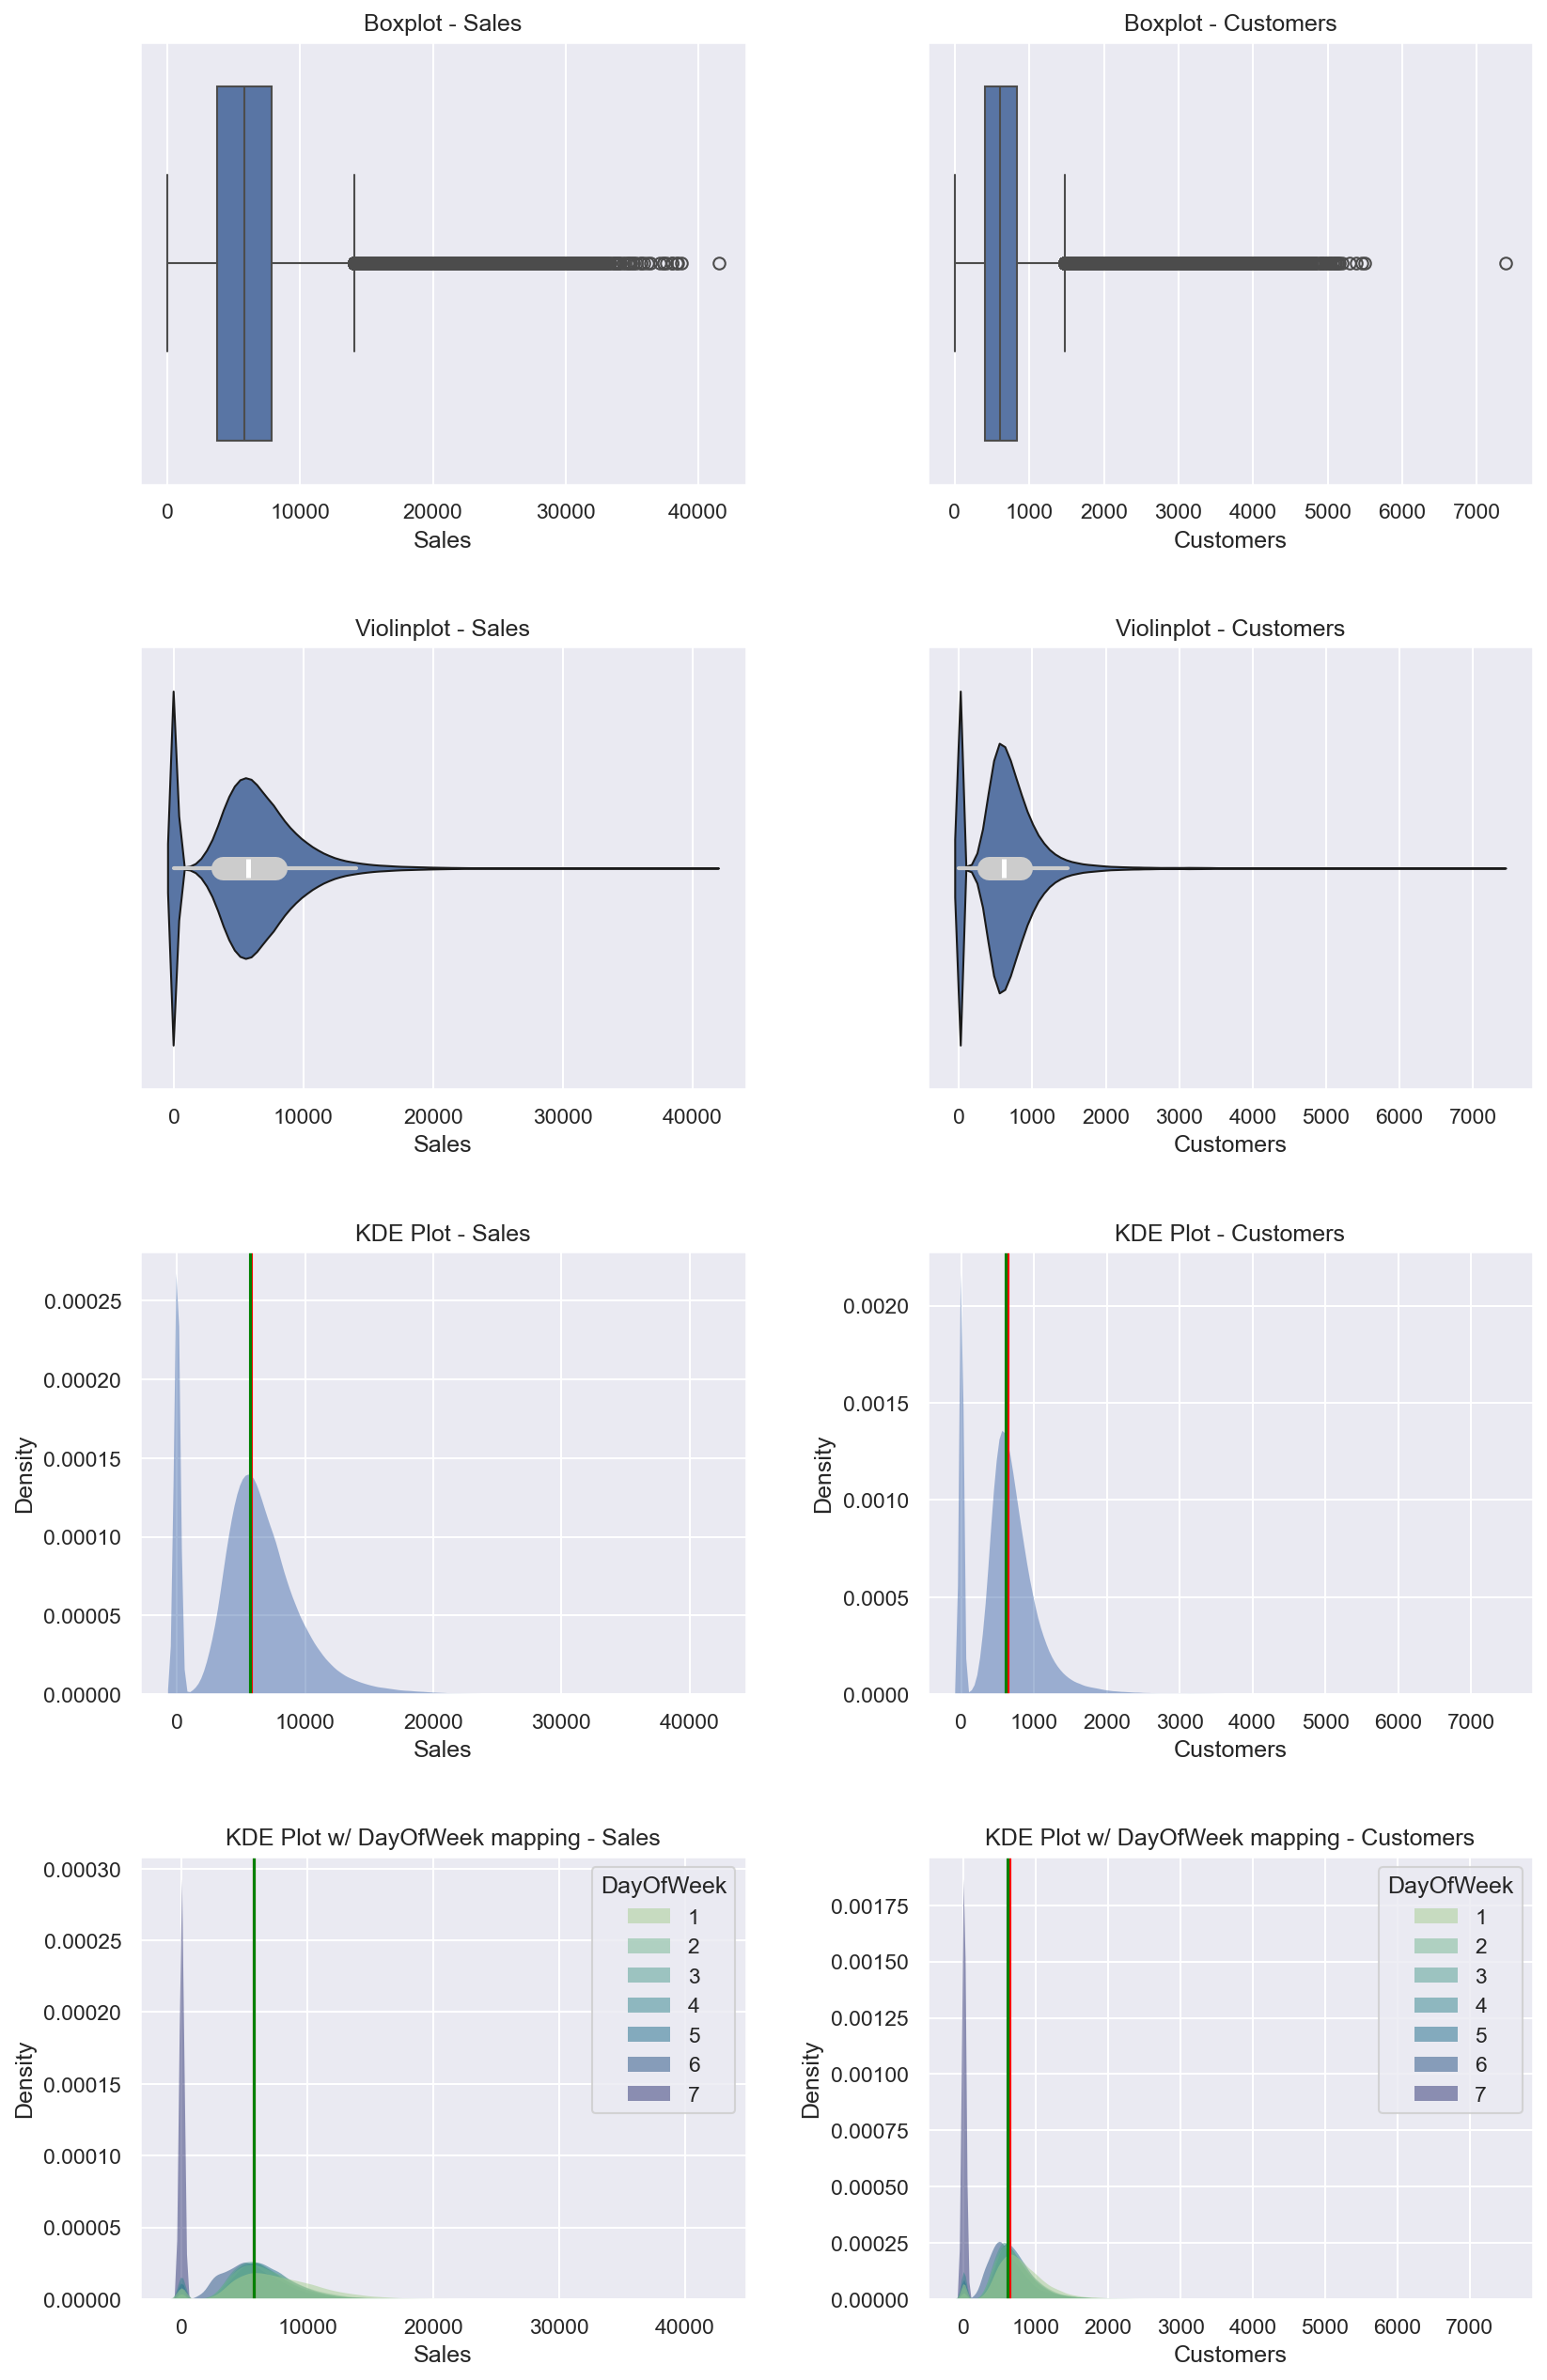

In [18]:
draw_distribution_plots(df=numeric_df)

**Some Notes**

- From the boxplot, we see that there are outliers for both Customers and Sales
- From the Violiplot, there were days that recorded 0 Customers and 0 Sales, possibly due to closures of some stores
- From the KDE plot, the variance between the mean and median sales is near-negligible if not completely negligible
- From the KDE plot, there is some variance between the mean and the median Customers
- For both KDE plots, there are significant numbers of 0 sales and 0 customers, as well as outliers
- From the last plot, it looks like a lot of the 0 sales and 0 customers occurred on the 7th day, possibly Sunday.
    - We can confirm which day this actually is in the next section (Seasonality)
- We shall need to clean up this data by treating the 0 values and outliers so we can get a normal distribution, before we build our model.

In [19]:
numeric_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
0,1,5,"5,263.00",555.00,1.00,1,1
1,2,5,"6,064.00",625.00,1.00,1,1
2,3,5,"8,314.00",821.00,1.00,1,1
3,4,5,"13,995.00","1,498.00",1.00,1,1
4,5,5,"4,822.00",559.00,1.00,1,1
...,...,...,...,...,...,...,...
41083,1111,6,NaN,NaN,1.00,0,0
41084,1112,6,NaN,NaN,1.00,0,0
41085,1113,6,NaN,NaN,1.00,0,0
41086,1114,6,NaN,NaN,1.00,0,0


### Data Cleaning

#### Handling null values

There are a total of 1,058,297 rows of data.

From the `.describe(...)` function call above, there are a total of:
- 41,088 `NAN` values for `Sales` column
- 41,088 `NAN` values for `Customers` column
- 11 `NAN` values for `Open` column
 
We shall drop all rows where at least one element is missing

In [20]:
prep_df = numeric_df.dropna()

In [21]:
prep_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
0,1,5,"5,263.00",555.00,1.00,1,1
1,2,5,"6,064.00",625.00,1.00,1,1
2,3,5,"8,314.00",821.00,1.00,1,1
3,4,5,"13,995.00","1,498.00",1.00,1,1
4,5,5,"4,822.00",559.00,1.00,1,1
...,...,...,...,...,...,...,...
1017204,1111,2,0.00,0.00,0.00,0,1
1017205,1112,2,0.00,0.00,0.00,0,1
1017206,1113,2,0.00,0.00,0.00,0,1
1017207,1114,2,0.00,0.00,0.00,0,1


#### Handling Zero Values

Total occurrences with 0 sales and 0 customers when stores were closed

In [22]:
((prep_df['Customers'] == 0) & (prep_df['Sales'] == 0) & (prep_df['Open'] == 0)).sum()

172817

Total occurrences with 0 sales and 0 customers when stores were open

In [23]:
((prep_df['Customers'] == 0) & (prep_df['Sales'] == 0) & (prep_df['Open'] == 1)).sum()

52

In [24]:
df[(df['Customers'] == 0) & (df['Sales'] == 0) & (df['Open'] == 1)][['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday
86825,971,5,0,0,1
142278,674,4,0,0,0
196938,699,4,1,0,0
322053,708,3,1,0,0
330176,357,1,0,0,0
340348,227,4,0,0,0
340860,835,4,0,0,0
341795,835,3,0,0,0
346232,548,5,1,0,1
346734,28,4,1,0,0


Drop rows with 0 sales and 0 customers where stores were closed

In [25]:
prep_df = prep_df[((prep_df['Customers'] > 0) & (prep_df['Sales'] > 0) & (prep_df['Open'] == 1))]

prep_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
0,1,5,"5,263.00",555.00,1.00,1,1
1,2,5,"6,064.00",625.00,1.00,1,1
2,3,5,"8,314.00",821.00,1.00,1,1
3,4,5,"13,995.00","1,498.00",1.00,1,1
4,5,5,"4,822.00",559.00,1.00,1,1
...,...,...,...,...,...,...,...
1016776,682,2,"3,375.00",566.00,1.00,0,1
1016827,733,2,"10,765.00","2,377.00",1.00,0,1
1016863,769,2,"5,035.00","1,248.00",1.00,0,1
1017042,948,2,"4,491.00","1,039.00",1.00,0,1


Let us examine what the distribution looks like now without the 0 values

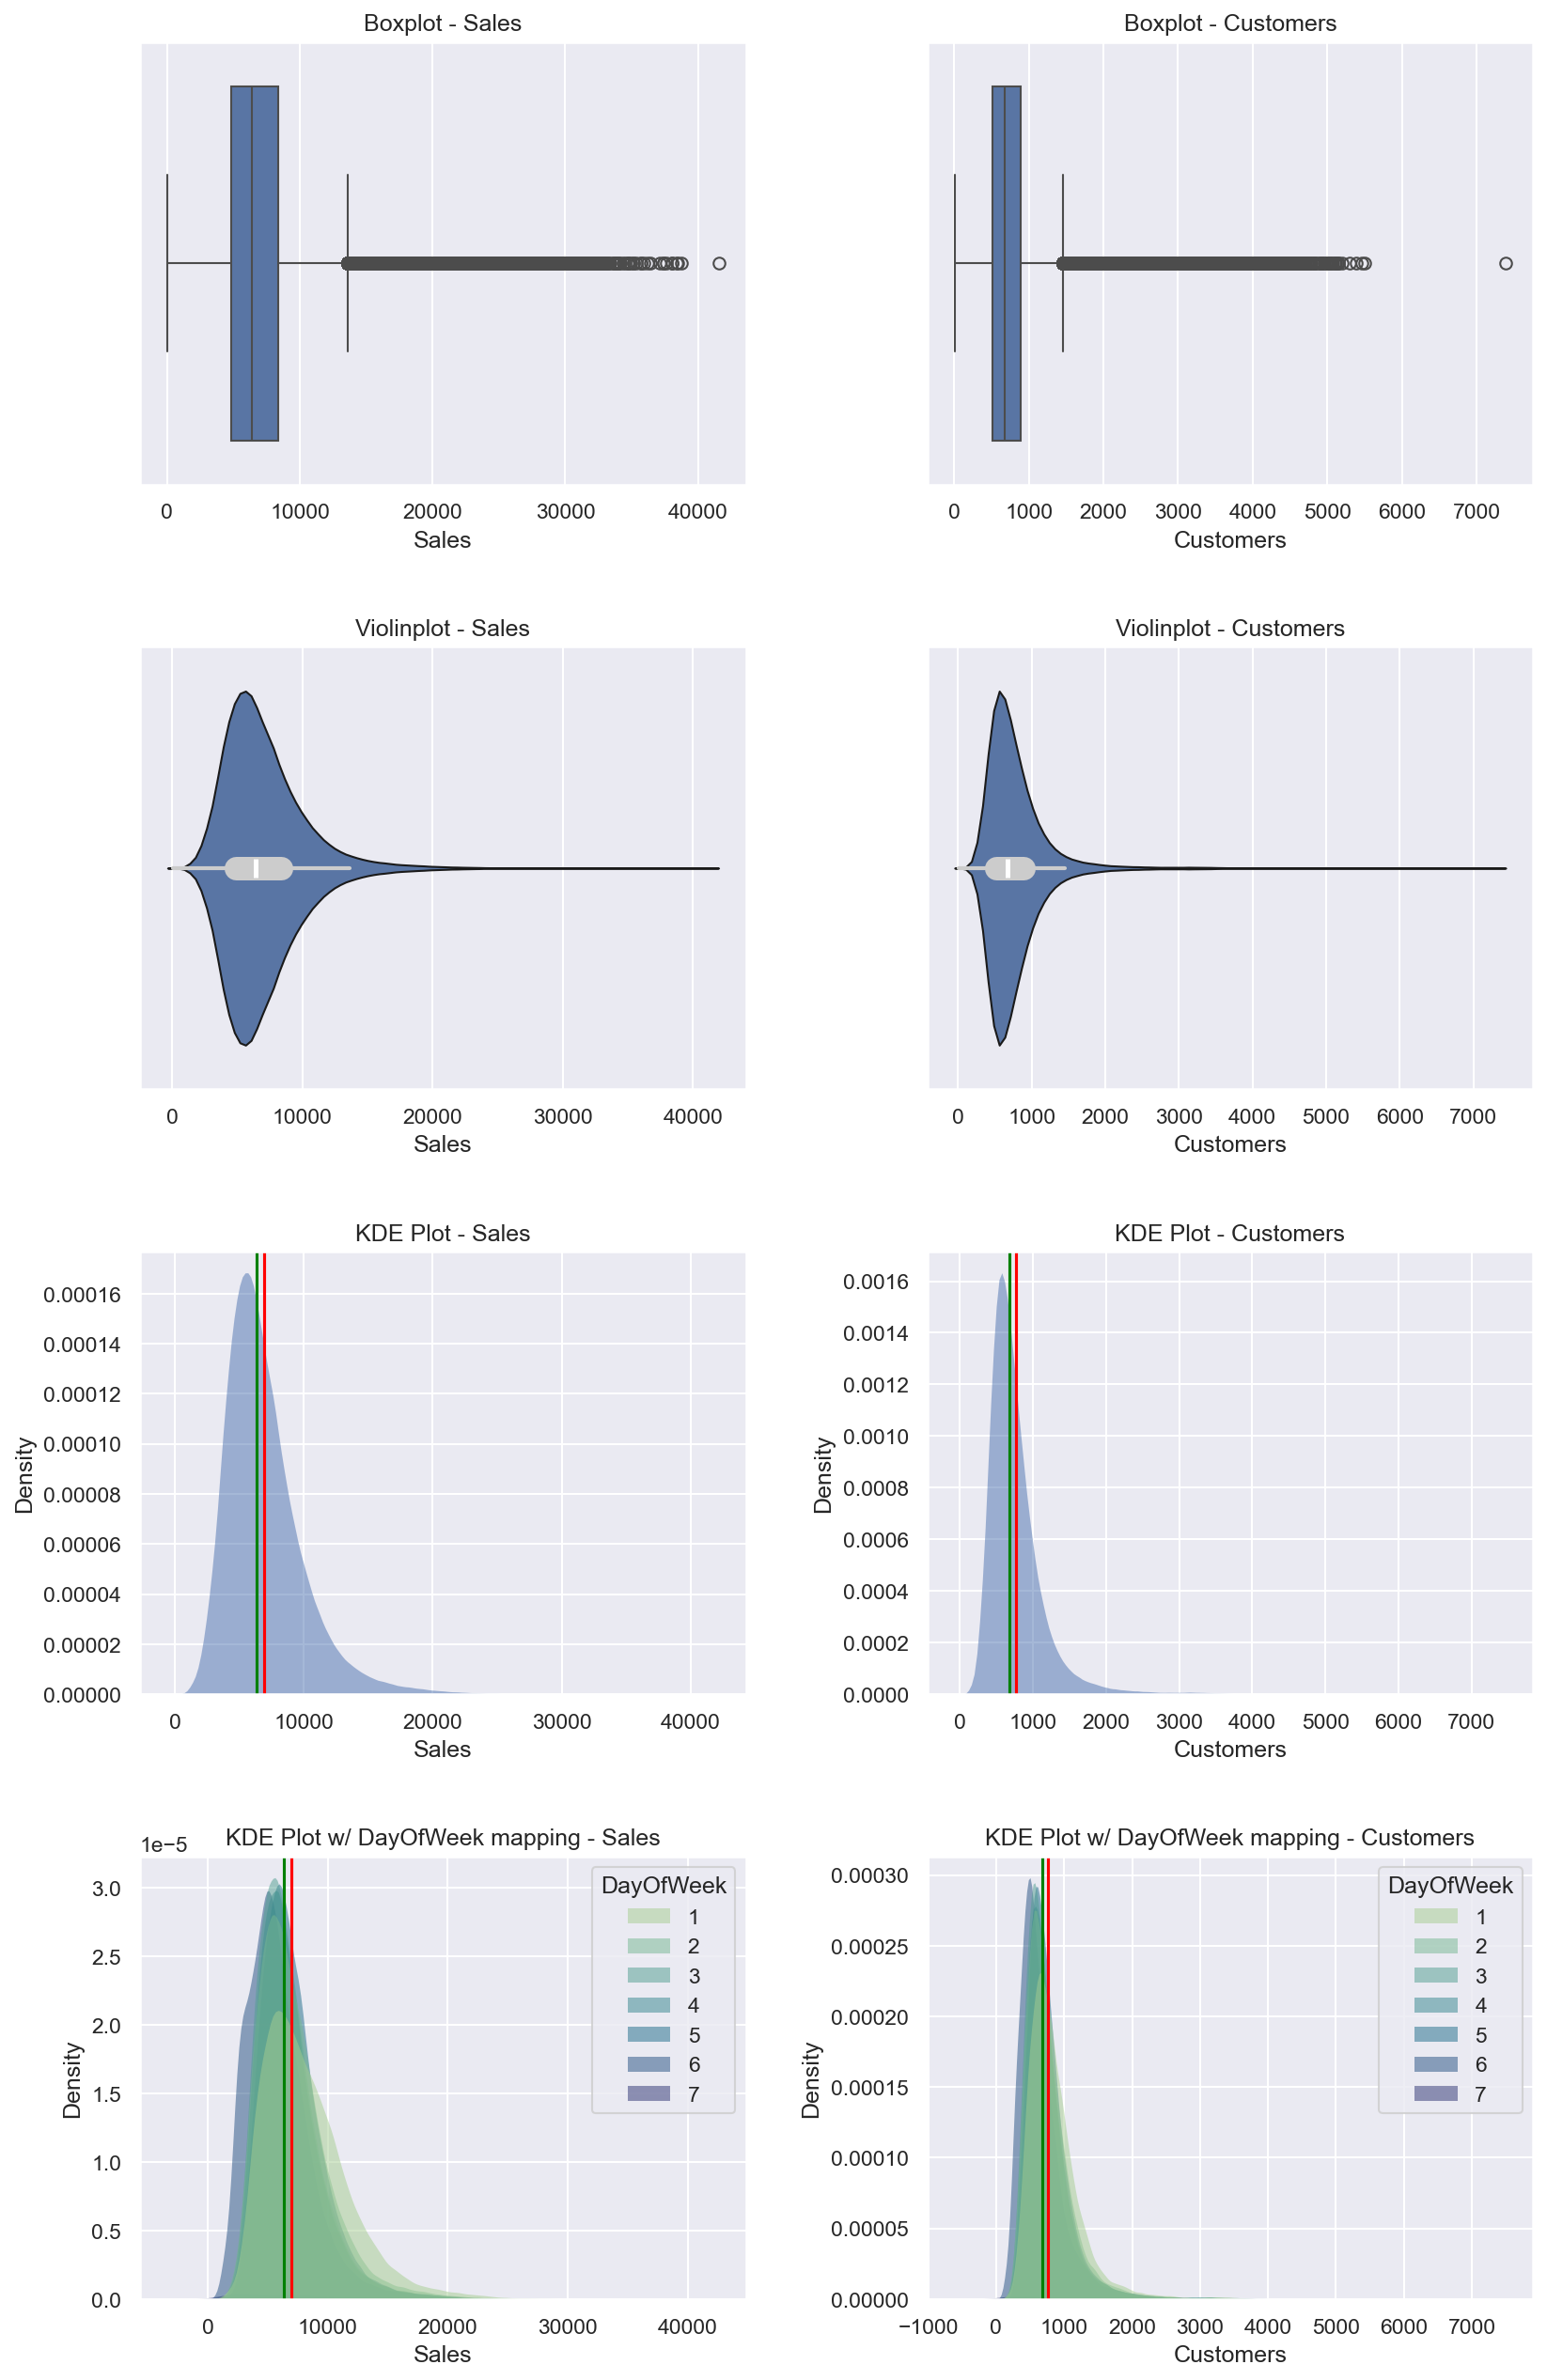

In [26]:
draw_distribution_plots(df=prep_df)

#### Handling Outliers

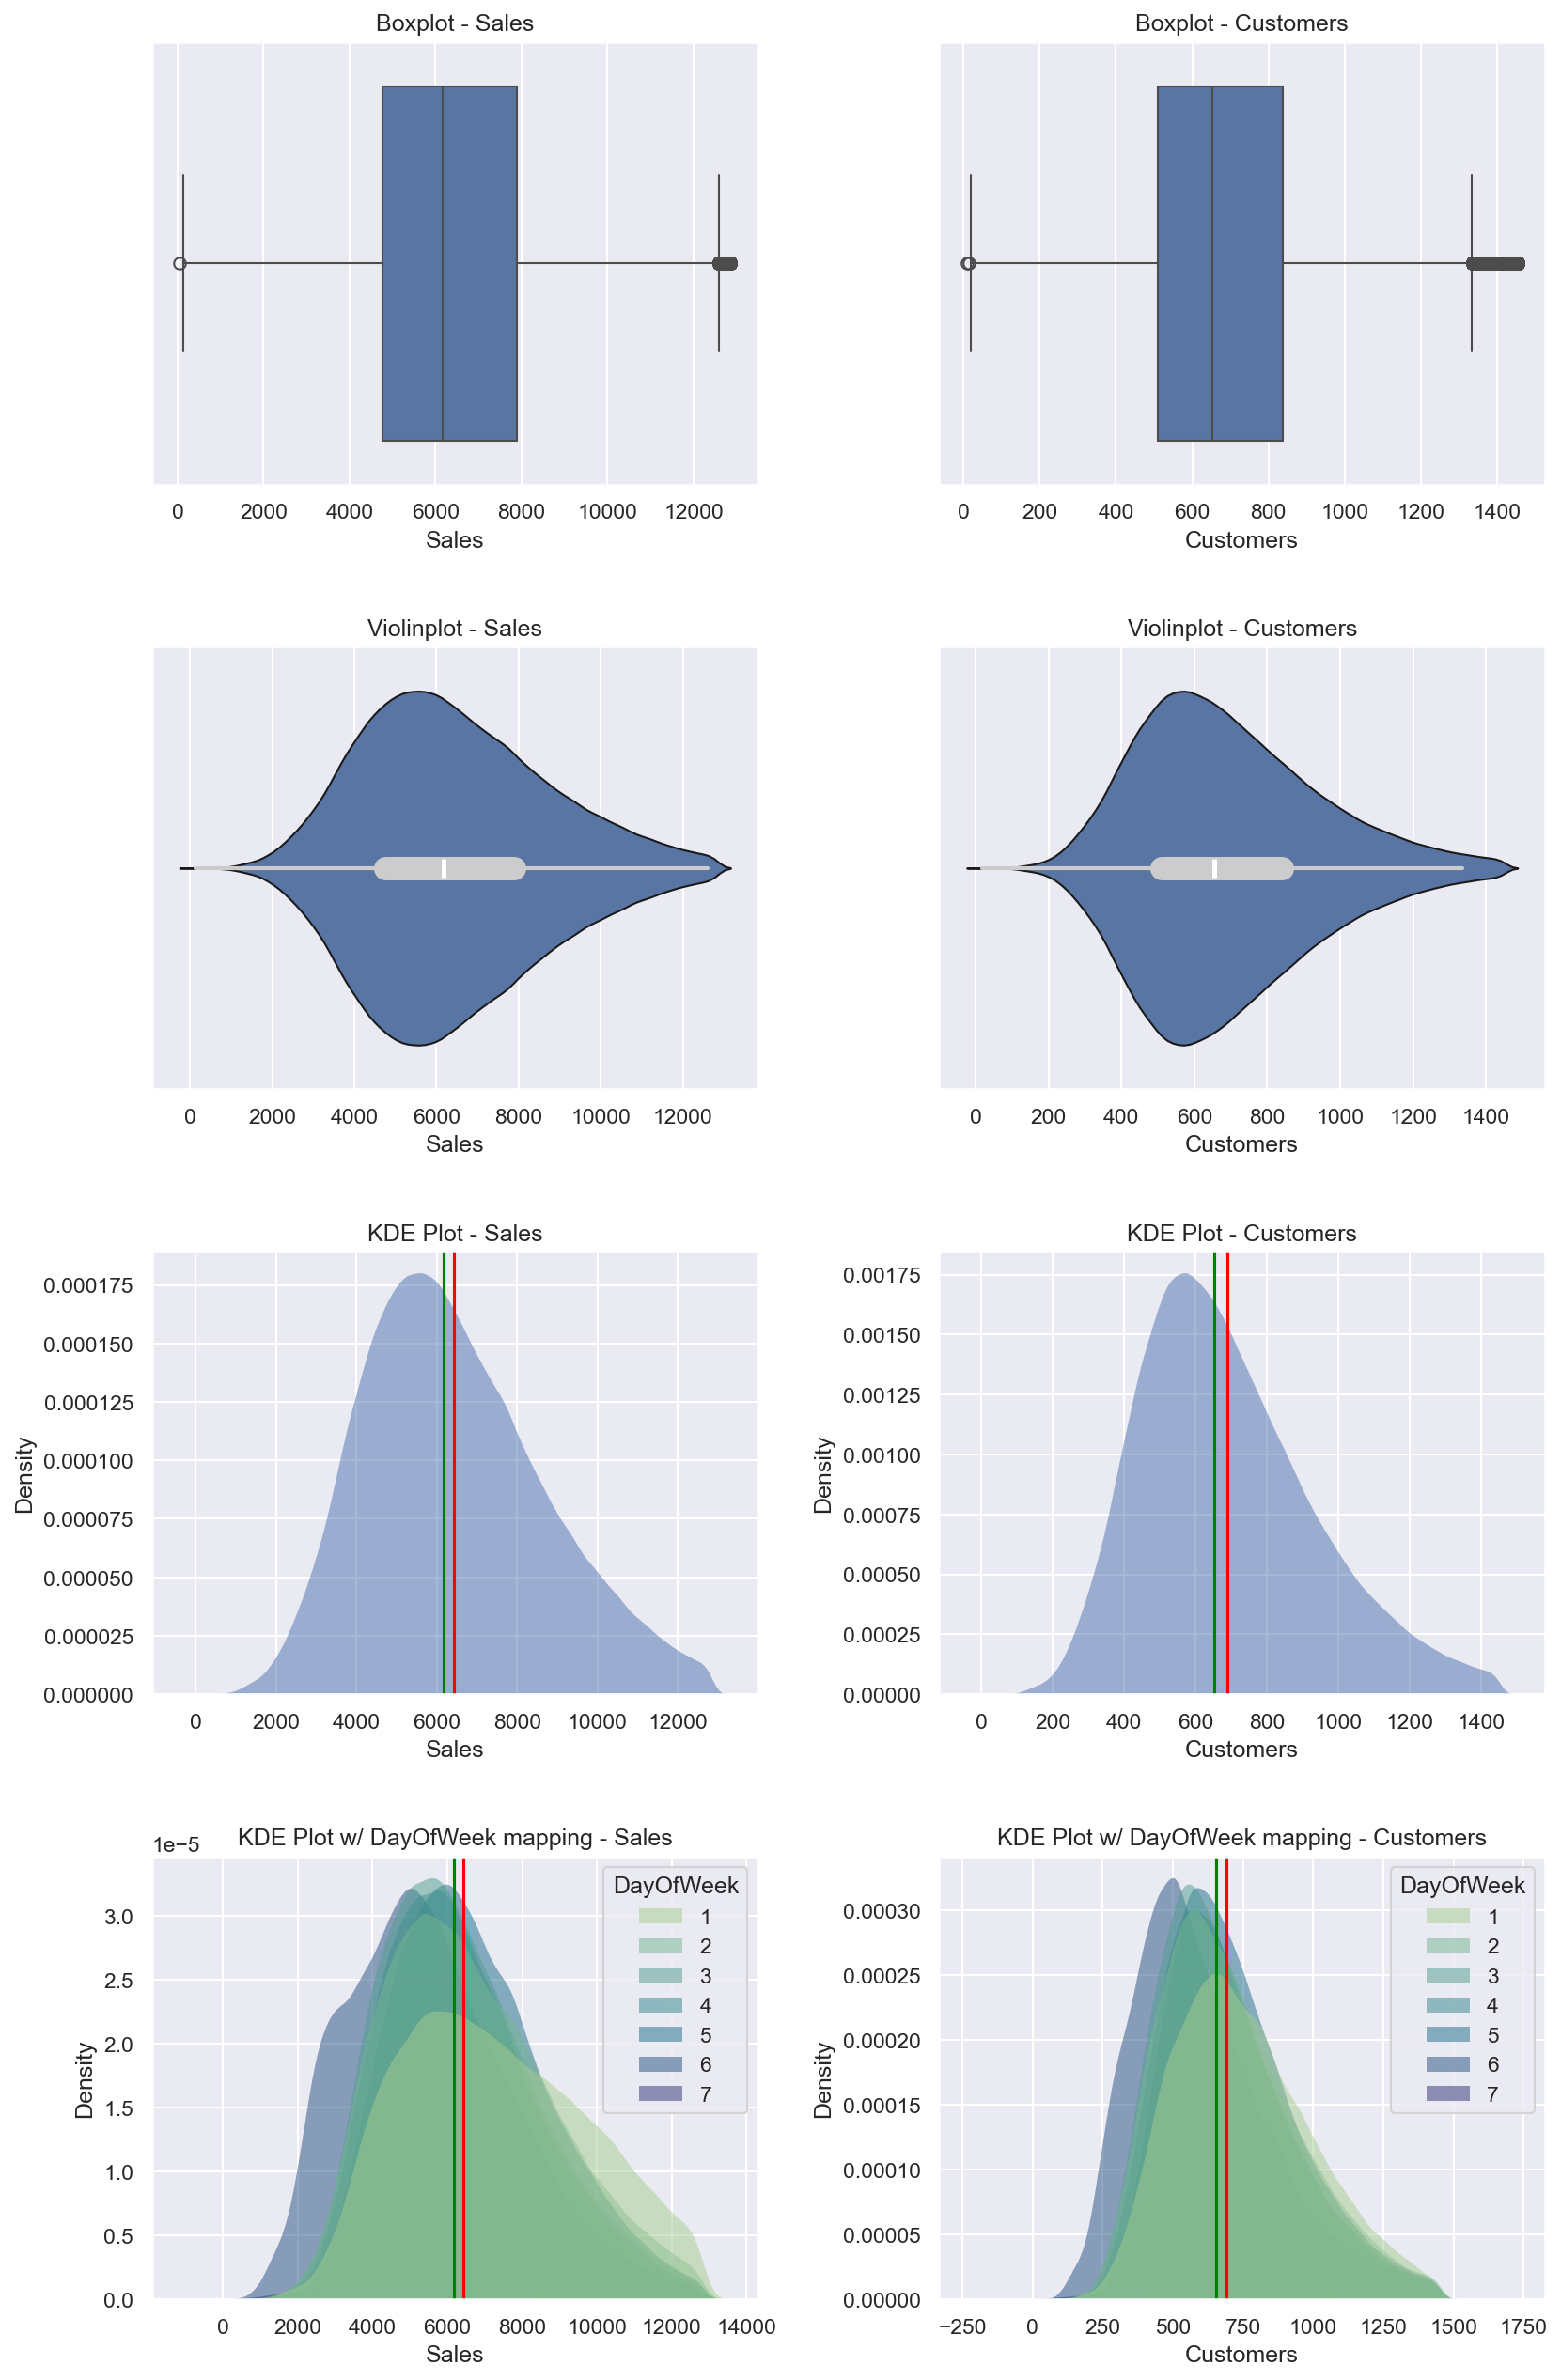

In [27]:
outlier_handler = OutlierHandler(df=prep_df)

prep_df = outlier_handler.remove_outliers()

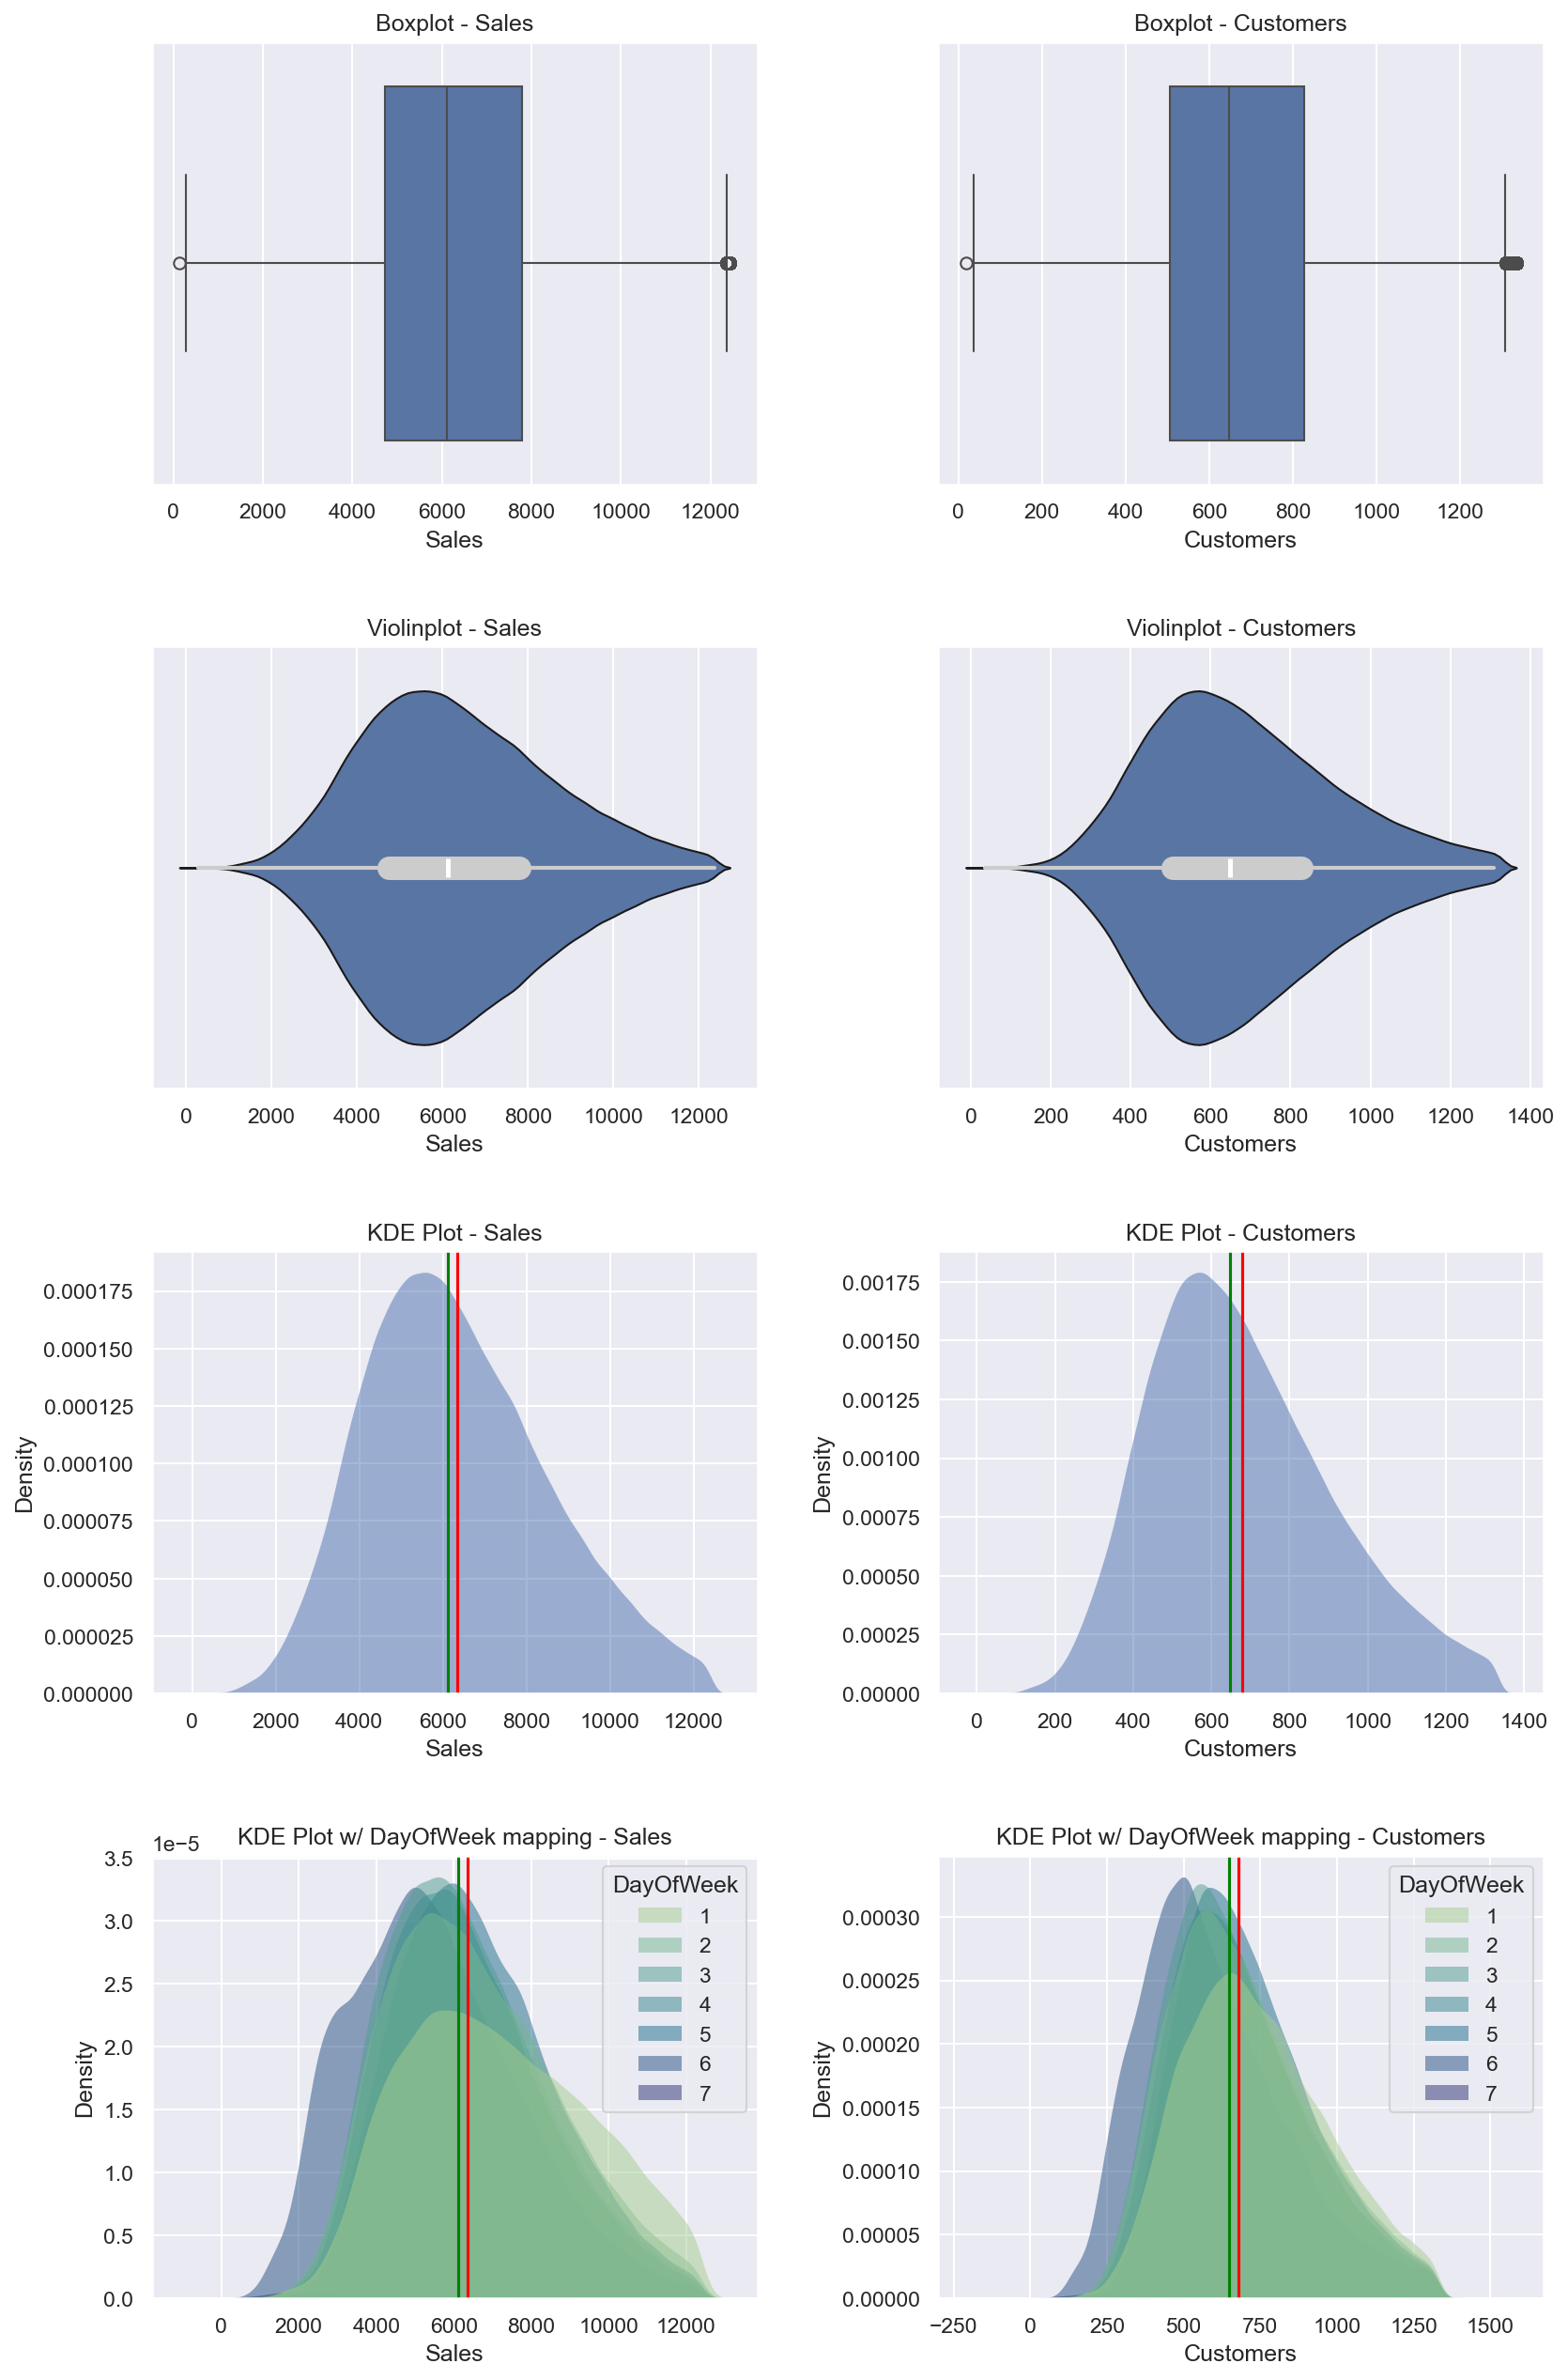

In [28]:
outlier_handler = OutlierHandler(df=prep_df)

prep_df = outlier_handler.remove_outliers()

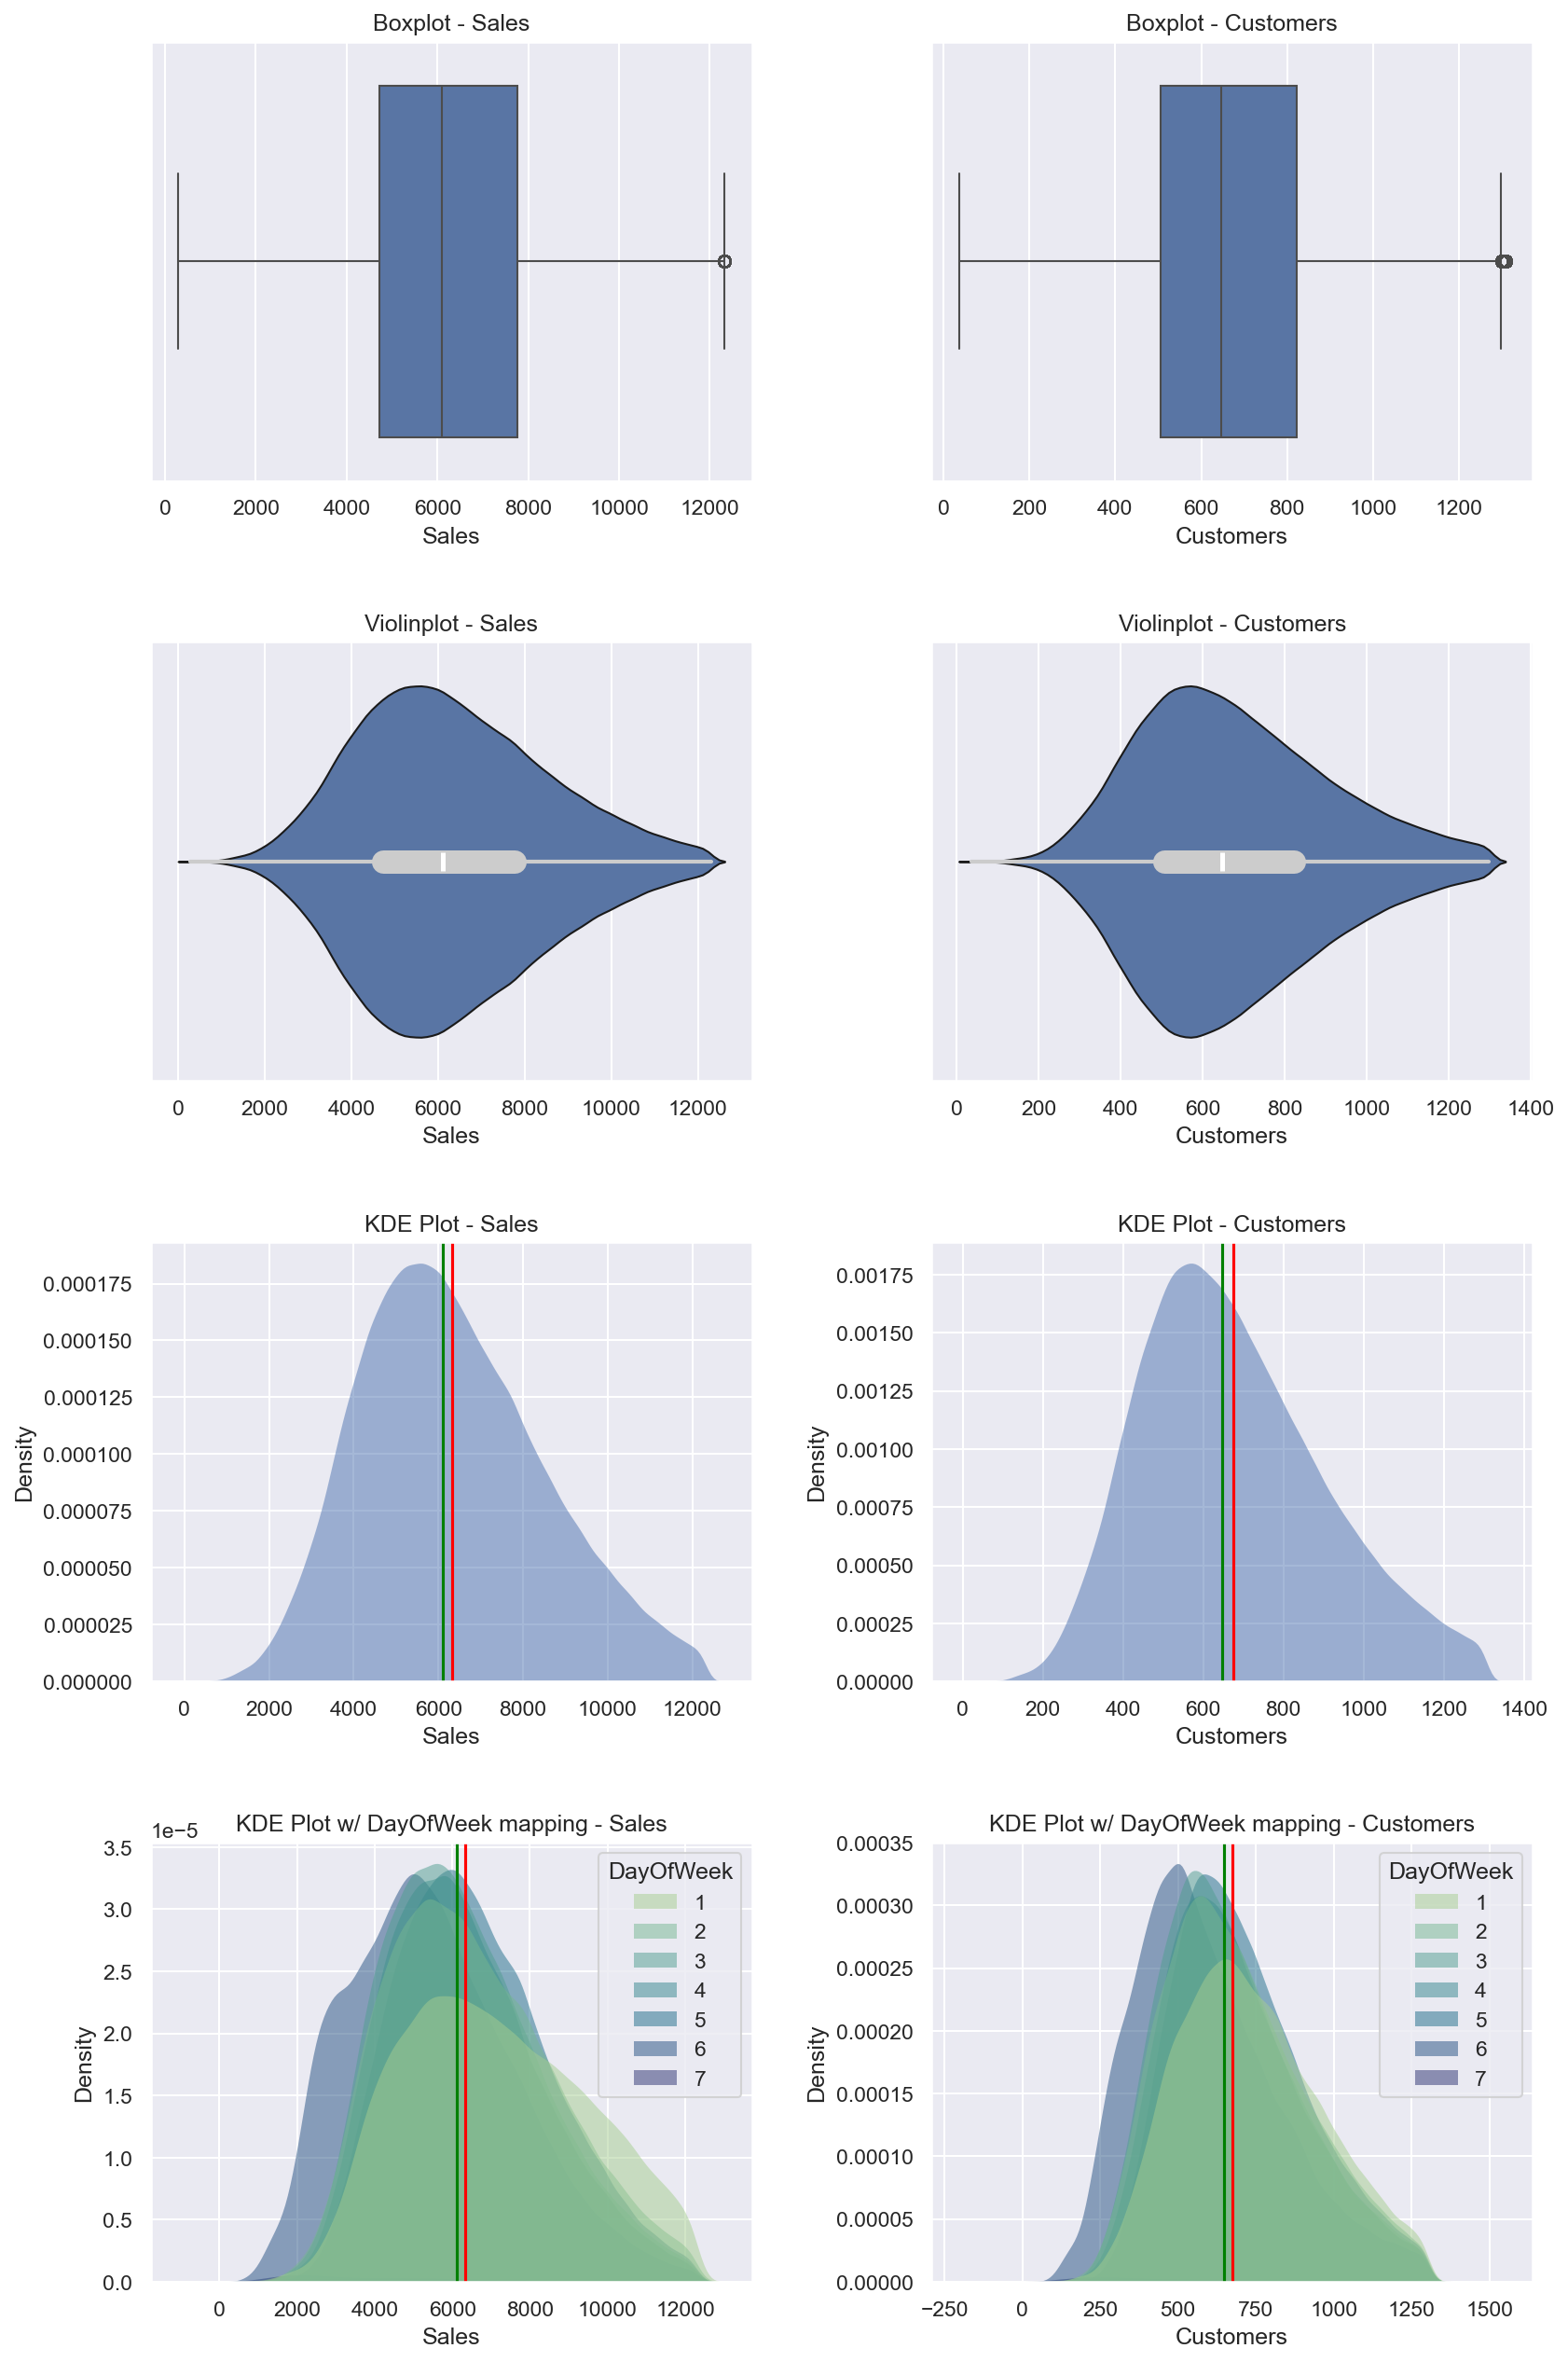

In [29]:
outlier_handler = OutlierHandler(df=prep_df)

prep_df = outlier_handler.remove_outliers()

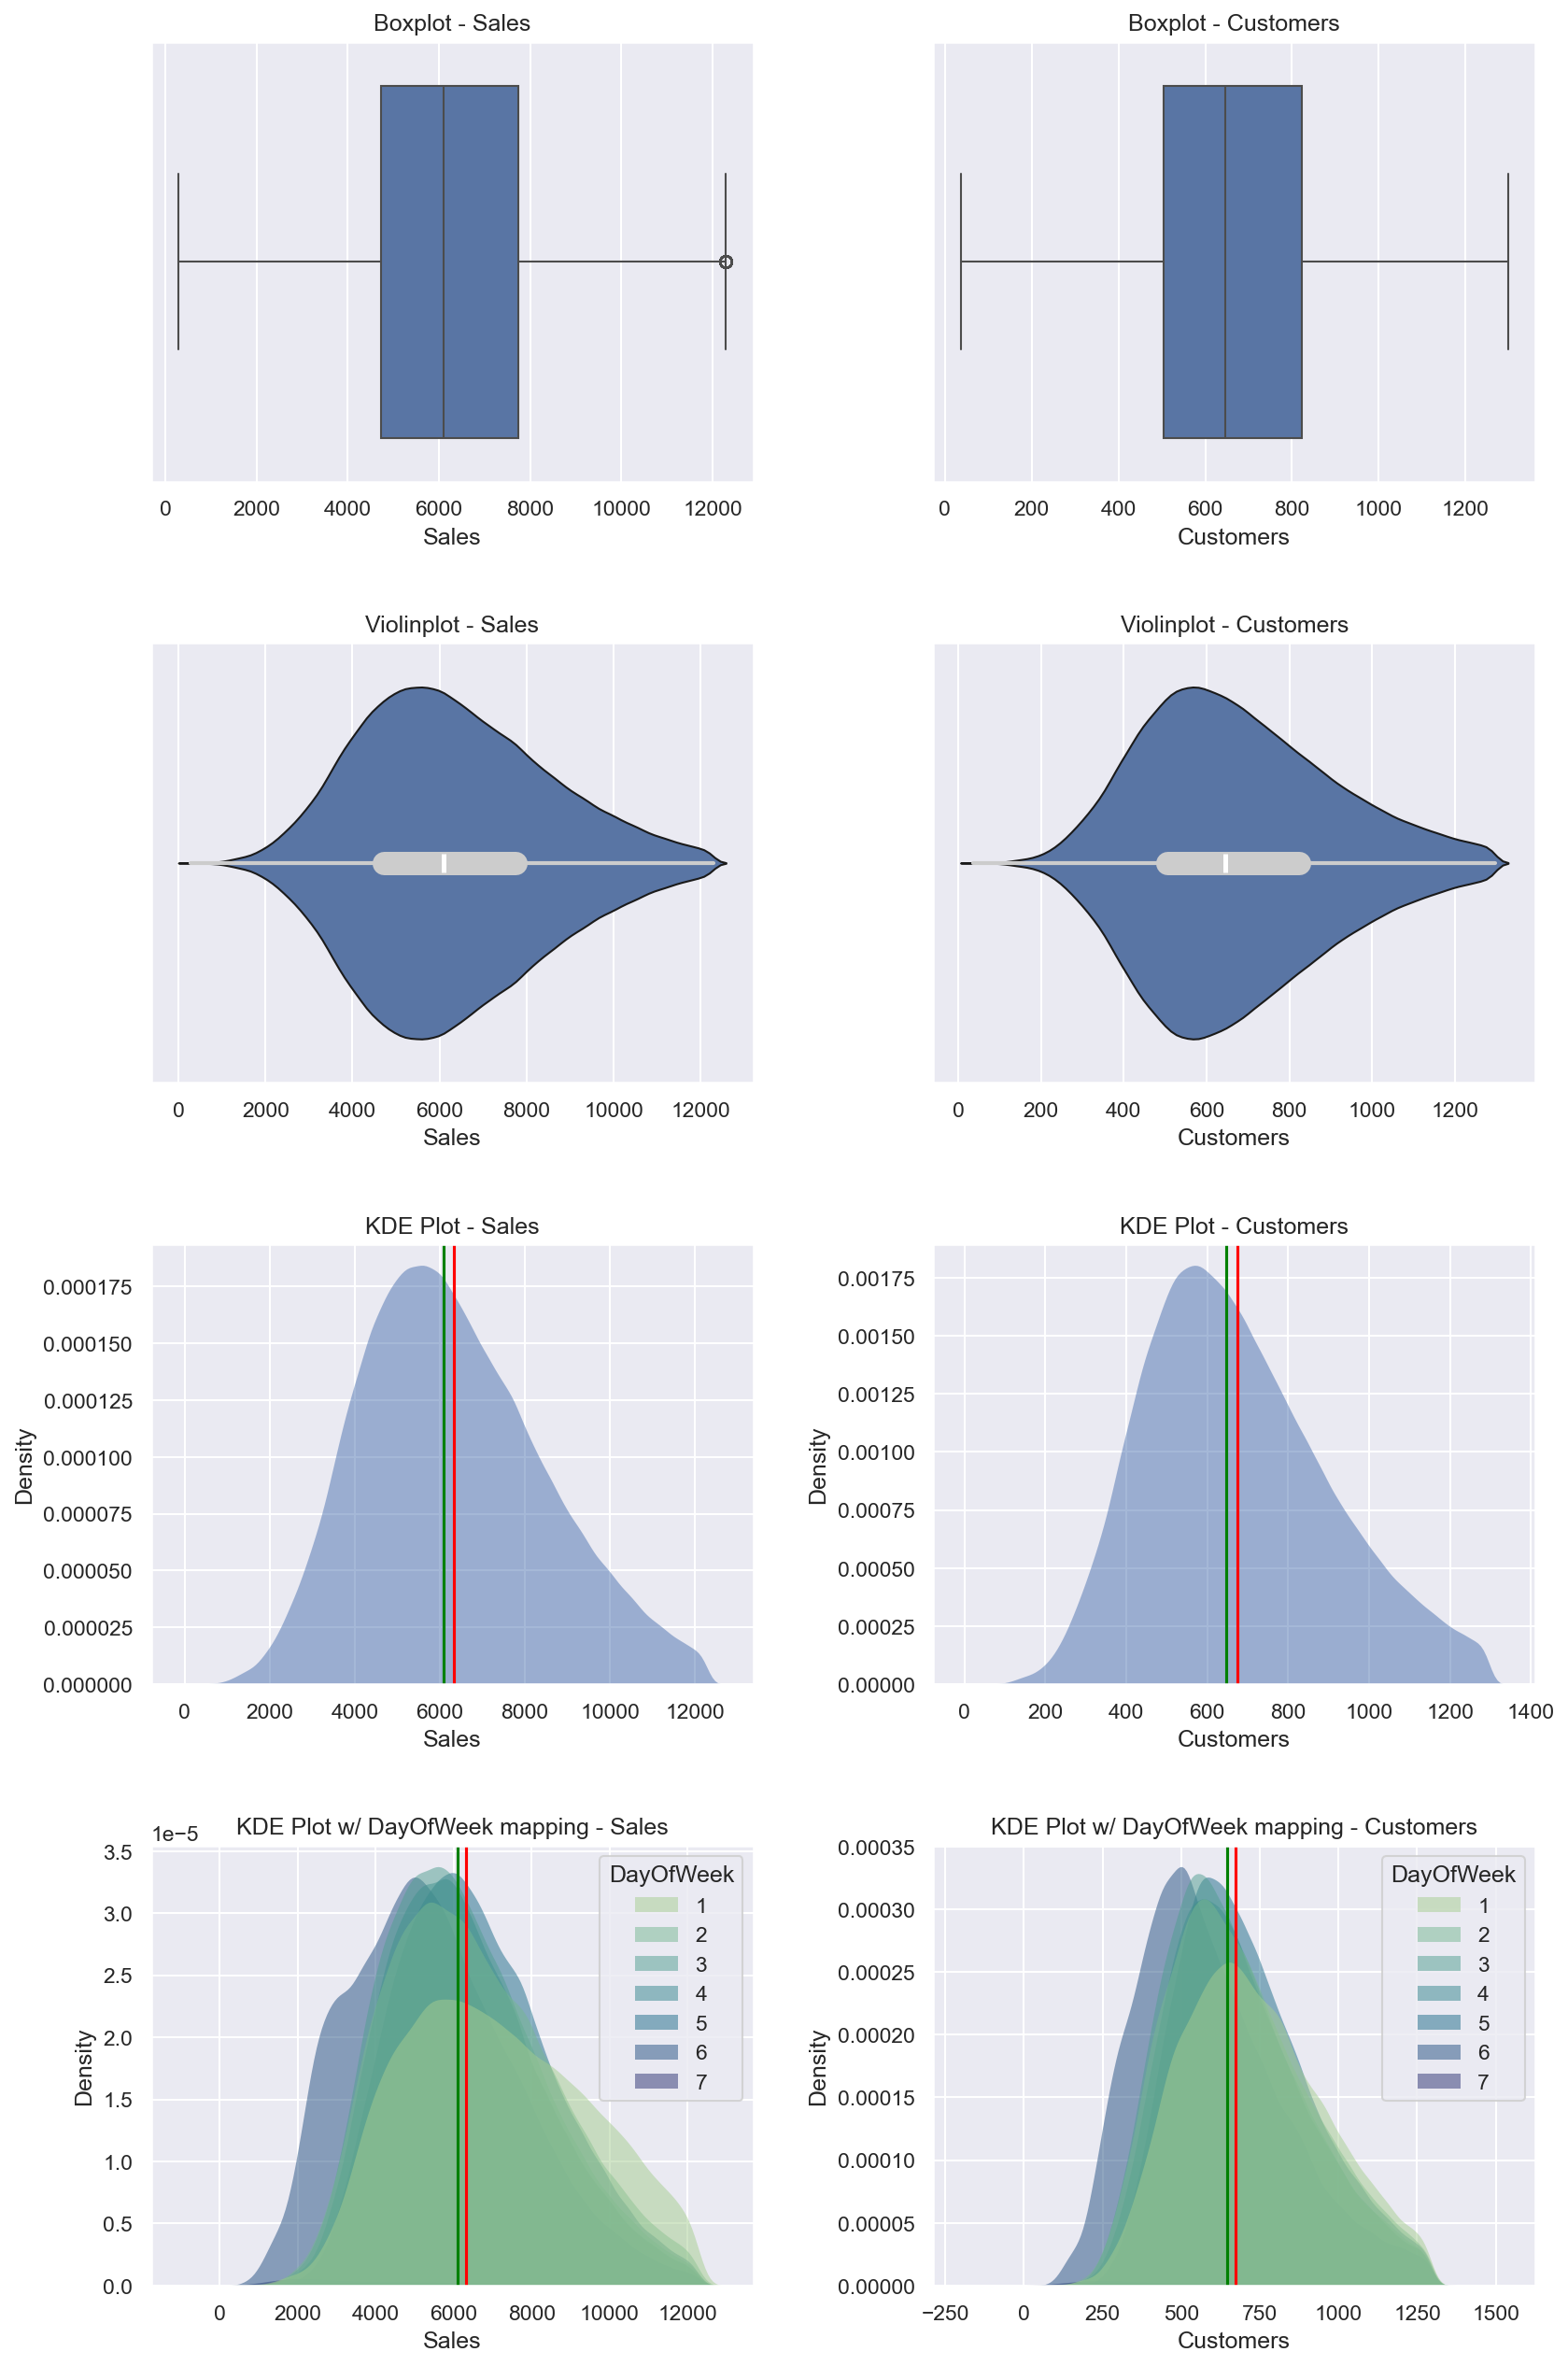

In [30]:
outlier_handler = OutlierHandler(df=prep_df)

prep_df = outlier_handler.remove_outliers()

In [31]:
prep_df.to_csv("./sales_data/prepped_data.csv")

## Modelling

### Train-Test Split

Resources: 

- [API Ref](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [User Guide](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics)

In [32]:
y = prep_df["Sales"]

x = prep_df.drop(["Sales", "Store"], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=.3)

In [34]:
X_train

,DayOfWeek,Customers,Open,Promo,SchoolHoliday
977747,2,912.00,1.00,1,0
743165,2,912.00,1.00,0,0
767259,2,"1,054.00",1.00,1,1
841215,5,663.00,1.00,1,0
57563,3,773.00,1.00,0,0
...,...,...,...,...,...
952725,3,287.00,1.00,0,0
283854,2,598.00,1.00,1,0
85439,6,271.00,1.00,0,0
281519,4,900.00,1.00,1,0


In [35]:
X_test

,DayOfWeek,Customers,Open,Promo,SchoolHoliday
798860,1,963.00,1.00,1,0
275702,3,535.00,1.00,0,0
32080,5,591.00,1.00,1,0
329376,2,579.00,1.00,0,0
845985,1,696.00,1.00,1,0
...,...,...,...,...,...
755452,5,534.00,1.00,0,0
416200,2,646.00,1.00,0,0
501432,2,615.00,1.00,0,0
1000395,3,818.00,1.00,0,0


In [36]:
y_train

977747   7,892.00
743165   6,222.00
767259   7,037.00
841215   5,854.00
57563    6,099.00
           ...   
952725   2,434.00
283854   9,177.00
85439    2,131.00
281519   9,965.00
71848    6,896.00
Name: Sales, Length: 538580, dtype: float64

In [37]:
y_test

798860    10,010.00
275702     5,679.00
32080      4,795.00
329376     6,116.00
845985     6,324.00
             ...   
755452     3,579.00
416200     6,423.00
501432     4,783.00
1000395    5,707.00
80289      5,893.00
Name: Sales, Length: 230820, dtype: float64

### Feature Selection

Feature selection is the process of isolating the most consistent, non-redundant, and relevant features to use in model construction. Methodically reducing the size of datasets is important as the size and variety of datasets continue to grow. The main goal of feature selection is to improve the performance of a predictive model and reduce the computational cost of modeling.

Resources:
- [Feature Selection - SKLearn](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Feature Selection](https://www.heavy.ai/technical-glossary/feature-selection#:~:text=Feature%20selection%20is%20the%20process,of%20datasets%20continue%20to%20grow.)
- [Feature Selection Techniques](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/)
- [Machine Learning Mastery](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
- [Basics of Feature Selection in Python**](https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python)

In [38]:
from sklearn.feature_selection import f_regression, SelectKBest

## Conclusions

## Next Steps